In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier


# Read in the Data

In [3]:
regular_season_detailed = pd.read_csv('RegularSeasonDetailedResults.csv')

regular_compact = pd.read_csv('RegularSeasonCompactResults.csv')

tourney_detailed = pd.read_csv('NCAATourneyDetailedResults.csv')

tourney_compact = pd.read_csv('NCAATourneyCompactResults.csv')

sample_sub_stage = pd.read_csv('SampleSubmissionStage2.csv')

teams = pd.read_csv('Teams.csv')

## Get train data 

### Function to get median or mean stats of team1 whether they lose or win for training set

In [4]:
def team1_stat(team1_copy, outcome, team_stat, central_tend):
    if outcome == 'win':
        team1_winning_df = team1_copy.copy()
        features = [col for col in team1_copy.columns if (col != 'Season') & (col != 'team1') & (col != team_stat)]
        team1_winning_df.drop(features, axis = 1, inplace = True)
        if central_tend == 'mean':
            team1_mean = team1_winning_df.groupby(['Season', 'team1']).mean()
            team1_mean = team1_mean.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+'_avg'})
            return team1_mean
        elif central_tend == 'median':
            team1_median = team1_winning_df.groupby(['Season', 'team1']).median()
            team1_median = team1_median.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+'_med'})
            return team1_median
        else:
            print('Error in central tendancy chosen')
    elif outcome == 'lose':
        team1_losing_df = team1_copy.copy()
        features = [col for col in team1_copy.columns if (col!= 'Season') & (col != 'team1') & (col != team_stat)]
        team1_losing_df.drop(features, axis =1, inplace = True)
        if central_tend == 'mean':
            team1_mean = team1_losing_df.groupby(['Season', 'team1']).mean()
            team1_mean = team1_mean.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+ '_avg'})
            return team1_mean
        elif central_tend == 'median':
            team1_median = team1_losing_df.groupby(['Season', 'team1']).median()
            team1_median = team1_median.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+'_med'})
            return team1_median
        else:
            print('Error in central tendancy chosen')
    else:
        print("It's win or lose people!")
 

### Function to get median or mean stats of team2 whether they lose or win for training set

In [5]:
def team2_stat(team2_copy, outcome, team_stat, central_tend):
    if outcome == 'win':
        team2_winning_df = team2_copy.copy()
        features = [col for col in team2_copy.columns if (col != 'Season') & (col != 'team2') & (col != team_stat)]
        team2_winning_df.drop(features, axis = 1, inplace = True)
        if central_tend == 'mean':
            team2_mean = team2_winning_df.groupby(['Season', 'team2']).mean()
            team2_mean = team2_mean.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+'_avg'})
            return team2_mean
        elif central_tend == 'median':
            team2_median = team2_winning_df.groupby(['Season', 'team2']).median()
            team2_median = team2_median.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+'_med'})
            return team2_median
        else:
            print('Error in central tendancy chosen')
    elif outcome == 'lose':
        team2_losing_df = team2_copy.copy()
        features = [col for col in team2_copy.columns if (col!= 'Season') & (col != 'team2') & (col != team_stat)]
        team2_losing_df.drop(features, axis =1, inplace = True)
        if central_tend == 'mean':
            team2_mean = team2_losing_df.groupby(['Season', 'team2']).mean()
            team2_mean = team2_mean.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+ '_avg'})
            return team2_mean
        elif central_tend == 'median':
            team2_median = team2_losing_df.groupby(['Season', 'team2']).median()
            team2_median = team2_median.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+'_med'})
            return team2_median
        else:
            print('Error in central tendancy chosen')
    else:
        print("It's win or lose people!")
            
        

### Getting the wins (target) columns

In [6]:
def win_columns(df): 
    games = []
    for row in df.to_dict('records'):
        for perspective in ['team1', 'team2']:
            game = {}
            game['Won'] = int(perspective == 'team1')
            if perspective == 'team1':
                team_letter = 'team1'
                opp_letter = 'team2'
            else:
                team_letter = 'team2'
                opp_letter = 'team1'
            team_stats = [k for k,v in row.items() if k[:5] == team_letter]
            opp_stats = [k for k,v in row.items() if k[:5] == opp_letter]

            for stat in team_stats:
                game_stat = 'team1' + stat[5:]
                game[game_stat] = row[stat]
            for stat in opp_stats:
                opp_stat = 'team2' + stat[5:]
                game[opp_stat] = row[stat]

            for general_stat in ['DayNum', 'NumOT', 'Season', 'WLoc']:
                game[general_stat] = row[general_stat]

            games.append(game)

    win_df = pd.DataFrame(games)
    return win_df

### Cleaning my data

In [7]:
def ncaa_train(regular_compact, regular_season_detailed):
    
    warnings.filterwarnings("ignore")
    #change column names to be more representative of what we're dealing with
    df_renamed = regular_compact.rename(columns = {'WTeamID':'team1', 'LTeamID': 'team2'}).query("Season > 2005")
    regular_season_detailed = regular_season_detailed.query("Season > 2005")
    
    # get the tournament seeds
    tourney_seeds = pd.read_csv('NCAATourneySeeds.csv')
    tourney_seeds_int = tourney_seeds.copy()
    tourney_seeds_int['seed_int'] = tourney_seeds_int.Seed.apply(lambda x: int(x[1:3]))
    tourney_seeds_int.drop('Seed', axis = 1, inplace = True)
    tour_seed_df = pd.merge(left = df_renamed, right = tourney_seeds_int, left_on = ['Season', 'team1'], right_on = ['Season', 'TeamID']).drop('TeamID', axis = 1)
    tour_seed_df.rename(columns = {'seed_int': 'team1seed'}, inplace = True)
    tour_seed_df = pd.merge(left = tour_seed_df, right = tourney_seeds_int, left_on = ['Season', 'team2'], right_on = ['Season', 'TeamID']).drop('TeamID', axis = 1)
    tour_seed_df.rename(columns = {'seed_int': 'team2seed'}, inplace = True)
    
    #create a win column with your dataframe
    winning = df_renamed[['Season', 'team1']]
    winning['wins'] = 1
    wins_per_season = winning.groupby(['Season', 'team1']).sum().reset_index()
    
    #create a lose column with your dataframe
    losing = df_renamed[['Season', 'team2']]
    losing['losses'] = 1
    loss_per_season = losing.groupby(['Season', 'team2']).sum().reset_index()
    
    #in each prediction a team can either be on team1 or team2 so have to account for all of those encounters
    #we make copies so that we don't override the original dataframe
    team1_wins = wins_per_season.copy()
    team1_wins.rename(columns = {'wins':'team1wins_season'}, inplace = True)
    team2_wins = wins_per_season.copy()
    team2_wins.rename(columns = {'team1': 'team2', 'wins': 'team2wins_season'}, inplace = True)
    team1_losses = loss_per_season.astype('int64').copy()
    team1_losses.rename(columns = {'team2': 'team1','losses':'team1losses_season'}, inplace = True)
    team2_losses = loss_per_season.astype('int64').copy()
    team2_losses.rename(columns = {'losses': 'team2losses_season'}, inplace = True)
    
    #combine the wins and loses for both teams
    combined_df = pd.merge(tour_seed_df, team1_wins, how='left', on = ['Season', 'team1'])
    combined_df = pd.merge(combined_df, team2_wins, how = 'left', on = ['Season', 'team2'])
    combined_df = pd.merge(combined_df, team1_losses, how = 'left', on = ['Season', 'team1'])
    combined_df = pd.merge(combined_df, team2_losses, how = 'left', on = ['Season', 'team2'])
    
    #then make a copy with just the season and teams to merge with stats data
    team1_season = combined_df[['Season', 'team1']].copy()
    team2_season = combined_df[['Season', 'team2']].copy()
    
    #using the detailed season we combine the dataframes for team 1 and team 2 wins and losses
    win_team1_detailed = pd.merge(team1_season, regular_season_detailed, how = 'left', left_on= ['Season', 'team1'], right_on= ['Season', 'WTeamID'])
    lose_team1_detailed = pd.merge(team1_season, regular_season_detailed, how = 'left', left_on= ['Season', 'team1'], right_on= ['Season', 'LTeamID'])
    win_team2_detailed = pd.merge(team2_season, regular_season_detailed, how = 'left', left_on= ['Season', 'team2'], right_on= ['Season', 'WTeamID'])
    lose_team2_detailed = pd.merge(team2_season, regular_season_detailed, how = 'left', left_on= ['Season', 'team2'], right_on= ['Season', 'LTeamID'])
    
    
    #Getting possesion stats
    win_team1_detailed['WPossession'] = win_team1_detailed.WFGA + (.44 * win_team1_detailed.WFTA) + win_team1_detailed.WTO - win_team1_detailed.WOR
    lose_team1_detailed['LPossession'] = lose_team1_detailed.LFGA + (.44 * lose_team1_detailed.LFTA) + lose_team1_detailed.LTO - lose_team1_detailed.LOR
    win_team2_detailed['WPossession'] = win_team2_detailed.WFGA + (.44 * win_team2_detailed.WFTA) + win_team2_detailed.WTO - win_team2_detailed.WOR
    lose_team2_detailed['LPossession'] = lose_team2_detailed.LFGA + (.44 * lose_team2_detailed.LFTA) + lose_team2_detailed.LTO - lose_team2_detailed.LOR
    
    #Offensive Efficiency (Offrtg) = 100 x (Points / Possessions)
    # Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions) (here we're calling LOffrtg)
    win_team1_detailed['WEff'] = 100 * (win_team1_detailed.WFGM/win_team1_detailed.WPossession)
    lose_team1_detailed['LEff'] = 100 * (lose_team1_detailed.LFGM/lose_team1_detailed.LPossession)
    win_team2_detailed['WEff'] = 100 * (win_team2_detailed.WFGM/win_team2_detailed.WPossession)
    lose_team2_detailed['LEff'] = 100 * (lose_team2_detailed.LFGM/lose_team2_detailed.LPossession)
          
    #EFG% = (FGM + (0.5 * 3PM)) / FGA
    win_team1_detailed['WEFG%'] = (win_team1_detailed.WFGM + (0.5 * win_team1_detailed.WFGM3))/ win_team1_detailed.WFGA
    lose_team1_detailed['LEFG%'] = (lose_team1_detailed.LFGM + (0.5 * lose_team1_detailed.LFGM3))/ lose_team1_detailed.LFGA
    win_team2_detailed['WEFG%'] = (win_team2_detailed.WFGM + (0.5 * win_team2_detailed.WFGM3))/ win_team2_detailed.WFGA
    lose_team2_detailed['LEFG%'] = (lose_team2_detailed.LFGM + (0.5 * lose_team2_detailed.LFGM3))/ lose_team2_detailed.LFGA
          
    #Offensive rebounding percentage (OREB%) = Offensive rebounds / (Offensive rebounds + Opponent defensive rebounds)
    #Defensive rebounding percentage (DREB%) = Defensive rebounds / (Defensive rebounds + Opponent offensive rebounds)
    win_team1_detailed['WREB%'] = win_team1_detailed.WOR/ (win_team1_detailed.WOR + win_team1_detailed.LDR)
    lose_team1_detailed['LREB%'] = lose_team1_detailed.LOR/ (lose_team1_detailed.LOR + lose_team1_detailed.WDR)
    win_team2_detailed['WREB%'] = win_team2_detailed.WOR/ (win_team2_detailed.WOR + win_team2_detailed.LDR)
    lose_team2_detailed['LREB%'] = lose_team2_detailed.LOR/ (lose_team2_detailed.LOR + lose_team2_detailed.WDR)
    
    #Turnover rate (TOR) = TOV / (FGA + 0.44 * FTA + TOV)
    win_team1_detailed['WTOR'] = win_team1_detailed.WTO / (win_team1_detailed.WFGA + 0.44*win_team1_detailed.WFTA + win_team1_detailed.WTO)
    lose_team1_detailed['LTOR'] = lose_team1_detailed.LTO / (lose_team1_detailed.LFGA + 0.44*lose_team1_detailed.LFTA + lose_team1_detailed.LTO)
    win_team2_detailed['WTOR'] = win_team2_detailed.WTO / (win_team2_detailed.WFGA + 0.44*win_team2_detailed.WFTA + win_team2_detailed.WTO)
    lose_team2_detailed['LTOR'] = lose_team2_detailed.LTO / (lose_team2_detailed.LFGA + 0.44*lose_team2_detailed.LFTA + lose_team2_detailed.LTO)
          
    #Freethrow percentage = FTA/FGA
    win_team1_detailed['WFT%'] = win_team1_detailed.WFTA / win_team1_detailed.WFGA
    lose_team1_detailed['LFT%'] = lose_team1_detailed.LFTA / lose_team1_detailed.LFGA
    win_team2_detailed['WFT%'] = win_team2_detailed.WFTA / win_team2_detailed.WFGA
    lose_team2_detailed['LFT%'] = lose_team2_detailed.LFTA / lose_team2_detailed.LFGA
          
    #Fieldgoal 2 points Attempts = FGA -FGA3
    win_team1_detailed['WFGA2'] = win_team1_detailed.WFGA - win_team1_detailed.WFGA3
    lose_team1_detailed['LFGA2'] = lose_team1_detailed.LFGA - lose_team1_detailed.LFGA3
    win_team2_detailed['WFGA2'] = win_team2_detailed.WFGA - win_team2_detailed.WFGA3
    lose_team2_detailed['LFGA2'] = lose_team2_detailed.LFGA - lose_team2_detailed.LFGA3
          
    #Fieldgoal 2 points Made = FGM - FGM3
    win_team1_detailed['WFGM2'] = win_team1_detailed.WFGM - win_team1_detailed.WFGM3
    lose_team1_detailed['LFGM2'] = lose_team1_detailed.LFGM - lose_team1_detailed.LFGM3
    win_team2_detailed['WFGM2'] = win_team2_detailed.WFGM - win_team2_detailed.WFGM3
    lose_team2_detailed['LFGM2'] = lose_team2_detailed.LFGM - lose_team2_detailed.LFGM3
    
    #PIE = (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / 
    # (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)
    win_team1_detailed['WPIE'] = ((win_team1_detailed.WScore + win_team1_detailed.WFGM + win_team1_detailed.WFTM - win_team1_detailed.WFGA - win_team1_detailed.WFTA + win_team1_detailed.LDR + (.5*win_team1_detailed.WOR) \
                                  + win_team1_detailed.WAst + win_team1_detailed.WStl + (.5 * win_team1_detailed.WBlk) - win_team1_detailed.WPF - win_team1_detailed.WTO) \
    / ((win_team1_detailed.WScore + win_team1_detailed.LScore) + (win_team1_detailed.WFGM + win_team1_detailed.LFGM) + (win_team1_detailed.WFTM + win_team1_detailed.LFTM) - (win_team1_detailed.WFGA + win_team1_detailed.LFGA)\
       - (win_team1_detailed.WFTA + win_team1_detailed.LFTA) + (win_team1_detailed.WDR + win_team1_detailed.LDR) + (.5 * (win_team1_detailed.WOR + win_team1_detailed.LOR)) + (win_team1_detailed.WAst + win_team1_detailed.LAst) +(win_team1_detailed.WStl + win_team1_detailed.LStl) + (.5 * (win_team1_detailed.WBlk + win_team1_detailed.LBlk)) - (win_team1_detailed.WPF + win_team1_detailed.LPF) - (win_team1_detailed.WTO + win_team1_detailed.LTO)))
    
    lose_team1_detailed['LPIE'] = ((lose_team1_detailed.LScore + lose_team1_detailed.LFGM + lose_team1_detailed.LFTM - lose_team1_detailed.LFGA - lose_team1_detailed.LFTA + lose_team1_detailed.WDR + (.5*lose_team1_detailed.LOR) + lose_team1_detailed.LAst + lose_team1_detailed.LStl + (.5 * lose_team1_detailed.LBlk) - lose_team1_detailed.LPF - lose_team1_detailed.LTO)\
                              / ((lose_team1_detailed.WScore + lose_team1_detailed.LScore) + (lose_team1_detailed.WFGM + lose_team1_detailed.LFGM) + (lose_team1_detailed.WFTM + lose_team1_detailed.LFTM) - (lose_team1_detailed.WFGA + lose_team1_detailed.LFGA) - (lose_team1_detailed.WFTA + lose_team1_detailed.LFTA) + (lose_team1_detailed.WDR + lose_team1_detailed.LDR)\
                           + (.5 * (lose_team1_detailed.WOR + lose_team1_detailed.LOR)) + (lose_team1_detailed.WAst + lose_team1_detailed.LAst) +(lose_team1_detailed.WStl + lose_team1_detailed.LStl) + (.5 * (lose_team1_detailed.WBlk + lose_team1_detailed.LBlk)) - (lose_team1_detailed.WPF + lose_team1_detailed.LPF) - (lose_team1_detailed.WTO + lose_team1_detailed.LTO)))
    win_team2_detailed['WPIE'] = ((win_team2_detailed.WScore + win_team2_detailed.WFGM + win_team2_detailed.WFTM - win_team2_detailed.WFGA - win_team2_detailed.WFTA + win_team2_detailed.LDR + (.5*win_team2_detailed.WOR) + win_team2_detailed.WAst + win_team2_detailed.WStl + (.5 * win_team2_detailed.WBlk) - win_team2_detailed.WPF - win_team2_detailed.WTO)\
                              / ((win_team2_detailed.WScore + win_team2_detailed.LScore) + (win_team2_detailed.WFGM + win_team2_detailed.LFGM) + (win_team2_detailed.WFTM + win_team2_detailed.LFTM) - (win_team2_detailed.WFGA + win_team2_detailed.LFGA) - (win_team2_detailed.WFTA + win_team2_detailed.LFTA) + (win_team2_detailed.WDR + win_team2_detailed.LDR)\
                           + (.5 * (win_team2_detailed.WOR + win_team2_detailed.LOR)) + (win_team2_detailed.WAst + win_team2_detailed.LAst) +(win_team2_detailed.WStl + win_team2_detailed.LStl) + (.5 * (win_team2_detailed.WBlk + win_team2_detailed.LBlk)) - (win_team2_detailed.WPF + win_team2_detailed.LPF) - (win_team2_detailed.WTO + win_team2_detailed.LTO)))
    lose_team2_detailed['LPIE'] = ((lose_team2_detailed.LScore + lose_team2_detailed.LFGM + lose_team2_detailed.LFTM - lose_team2_detailed.LFGA - lose_team2_detailed.LFTA + lose_team2_detailed.WDR + (.5*lose_team2_detailed.LOR) + lose_team2_detailed.LAst + lose_team2_detailed.LStl + (.5 * lose_team2_detailed.LBlk) - lose_team2_detailed.LPF - lose_team2_detailed.LTO)\
                              / ((lose_team2_detailed.WScore + lose_team2_detailed.LScore) + (lose_team2_detailed.WFGM + lose_team2_detailed.LFGM) + (lose_team2_detailed.WFTM + lose_team2_detailed.LFTM) - (lose_team2_detailed.WFGA + lose_team2_detailed.LFGA) - (lose_team2_detailed.WFTA + lose_team2_detailed.LFTA) + (lose_team2_detailed.WDR + lose_team2_detailed.LDR)\
                           + (.5 * (lose_team2_detailed.WOR + lose_team2_detailed.LOR)) + (lose_team2_detailed.WAst + lose_team2_detailed.LAst) +(lose_team2_detailed.WStl + lose_team2_detailed.LStl) + (.5 * (lose_team2_detailed.WBlk + lose_team2_detailed.LBlk)) - (lose_team2_detailed.WPF + lose_team2_detailed.LPF) - (lose_team2_detailed.WTO + lose_team2_detailed.LTO)))
    
    
    # get the median win stats for team1
    team1_wscore_median = team1_stat(win_team1_detailed, 'win', 'WScore', 'median')
    team1_wfgm_median = team1_stat(win_team1_detailed, 'win', 'WFGM', 'median')
    team1_wfga_median = team1_stat(win_team1_detailed, 'win', 'WFGA', 'median')
    team1_wfgm3_median = team1_stat(win_team1_detailed, 'win', 'WFGM3', 'median')
    team1_wfga3_median = team1_stat(win_team1_detailed, 'win', 'WFGA3', 'median')
    team1_wftm_median = team1_stat(win_team1_detailed, 'win', 'WFTM', 'median')
    team1_wfta_median = team1_stat(win_team1_detailed, 'win', 'WFTA', 'median')
    team1_wor_median = team1_stat(win_team1_detailed, 'win', 'WOR', 'median')
    team1_wdr_median = team1_stat(win_team1_detailed, 'win', 'WDR', 'median')
    team1_wast_median = team1_stat(win_team1_detailed, 'win', 'WAst', 'median')
    team1_wstl_median = team1_stat(win_team1_detailed, 'win', 'WStl', 'median')
    team1_wblk_median = team1_stat(win_team1_detailed, 'win', 'WBlk', 'median')
    team1_wpf_median = team1_stat(win_team1_detailed, 'win', 'WPF', 'median')
    team1_wpos_median = team1_stat(win_team1_detailed, 'win', 'WPossession', 'median')
    team1_weff_median = team1_stat(win_team1_detailed, 'win', 'WEff', 'median')
    team1_wefgp_median = team1_stat(win_team1_detailed, 'win', 'WEFG%', 'median')
    team1_wrebp_median = team1_stat(win_team1_detailed, 'win', 'WREB%', 'median')
    team1_wtor_median = team1_stat(win_team1_detailed, 'win', 'WTOR', 'median')
    team1_wftp_median = team1_stat(win_team1_detailed, 'win', 'WFT%', 'median')
    team1_wfga2_median = team1_stat(win_team1_detailed, 'win', 'WFGA2', 'median')
    team1_wfgm2_median = team1_stat(win_team1_detailed, 'win', 'WFGM2', 'median')
    team1_wpie_median = team1_stat(win_team1_detailed, 'win', 'WPIE', 'median')
    
    #get the median lose stats for team1
    team1_lscore_median = team1_stat(lose_team1_detailed, 'lose', 'LScore', 'median')
    team1_lfgm_median = team1_stat(lose_team1_detailed, 'lose', 'LFGM', 'median')
    team1_lfga_median = team1_stat(lose_team1_detailed, 'lose', 'LFGA', 'median')
    team1_lfgm3_median = team1_stat(lose_team1_detailed, 'lose', 'LFGM3', 'median')
    team1_lfga3_median = team1_stat(lose_team1_detailed, 'lose', 'LFGA3', 'median')
    team1_lftm_median = team1_stat(lose_team1_detailed, 'lose', 'LFTM', 'median')
    team1_lfta_median = team1_stat(lose_team1_detailed, 'lose', 'LFTA', 'median')
    team1_lor_median = team1_stat(lose_team1_detailed, 'lose', 'LOR', 'median')
    team1_ldr_median = team1_stat(lose_team1_detailed, 'lose', 'LDR', 'median')
    team1_last_median = team1_stat(lose_team1_detailed, 'lose', 'LAst', 'median')
    team1_lstl_median = team1_stat(lose_team1_detailed, 'lose', 'LStl', 'median')
    team1_lblk_median = team1_stat(lose_team1_detailed, 'lose', 'LBlk', 'median')
    team1_lpf_median = team1_stat(lose_team1_detailed, 'lose', 'LPF', 'median')
    team1_lpos_median = team1_stat(lose_team1_detailed, 'lose', 'LPossession', 'median')
    team1_leff_median = team1_stat(lose_team1_detailed, 'lose', 'LEff', 'median')
    team1_lefgp_median = team1_stat(lose_team1_detailed, 'lose', 'LEFG%', 'median')
    team1_lrebp_median = team1_stat(lose_team1_detailed, 'lose', 'LREB%', 'median')
    team1_ltor_median = team1_stat(lose_team1_detailed, 'lose', 'LTOR', 'median')
    team1_lftp_median = team1_stat(lose_team1_detailed, 'lose', 'LFT%', 'median')
    team1_lfga2_median = team1_stat(lose_team1_detailed, 'lose', 'LFGA2', 'median')
    team1_lfgm2_median = team1_stat(lose_team1_detailed, 'lose', 'LFGM2', 'median')
    team1_lpie_median = team1_stat(lose_team1_detailed, 'lose', 'LPIE', 'median')
   
    #get the median win stats for team2
    team2_wscore_median = team2_stat(win_team2_detailed, 'win', 'WScore', 'median')
    team2_wfgm_median = team2_stat(win_team2_detailed, 'win', 'WFGM', 'median')
    team2_wfga_median = team2_stat(win_team2_detailed, 'win', 'WFGA', 'median')
    team2_wfgm3_median = team2_stat(win_team2_detailed, 'win', 'WFGM3', 'median')
    team2_wfga3_median = team2_stat(win_team2_detailed, 'win', 'WFGA3', 'median')
    team2_wftm_median = team2_stat(win_team2_detailed, 'win', 'WFTM', 'median')
    team2_wfta_median = team2_stat(win_team2_detailed, 'win', 'WFTA', 'median')
    team2_wor_median = team2_stat(win_team2_detailed, 'win', 'WOR', 'median')
    team2_wdr_median = team2_stat(win_team2_detailed, 'win', 'WDR', 'median')
    team2_wast_median = team2_stat(win_team2_detailed, 'win', 'WAst', 'median')
    team2_wstl_median = team2_stat(win_team2_detailed, 'win', 'WStl', 'median')
    team2_wblk_median = team2_stat(win_team2_detailed, 'win', 'WBlk', 'median')
    team2_wpf_median = team2_stat(win_team2_detailed, 'win', 'WPF', 'median')
    team2_wpos_median = team2_stat(win_team2_detailed, 'win', 'WPossession', 'median')
    team2_weff_median = team2_stat(win_team2_detailed, 'win', 'WEff', 'median')
    team2_wefgp_median = team2_stat(win_team2_detailed, 'win', 'WEFG%', 'median')
    team2_wrebp_median = team2_stat(win_team2_detailed, 'win', 'WREB%', 'median')
    team2_wtor_median = team2_stat(win_team2_detailed, 'win', 'WTOR', 'median')
    team2_wftp_median = team2_stat(win_team2_detailed, 'win', 'WFT%', 'median')
    team2_wfga2_median = team2_stat(win_team2_detailed, 'win', 'WFGA2', 'median')
    team2_wfgm2_median = team2_stat(win_team2_detailed, 'win', 'WFGM2', 'median')
    team2_wpie_median = team2_stat(win_team2_detailed, 'win', 'WPIE', 'median')
    
    #get the median lose stats for team2
    team2_lscore_median = team2_stat(lose_team2_detailed, 'lose', 'LScore', 'median')
    team2_lfgm_median = team2_stat(lose_team2_detailed, 'lose', 'LFGM', 'median')
    team2_lfga_median = team2_stat(lose_team2_detailed, 'lose', 'LFGA', 'median')
    team2_lfgm3_median = team2_stat(lose_team2_detailed, 'lose', 'LFGM3', 'median')
    team2_lfga3_median = team2_stat(lose_team2_detailed, 'lose', 'LFGA3', 'median')
    team2_lftm_median = team2_stat(lose_team2_detailed, 'lose', 'LFTM', 'median')
    team2_lfta_median = team2_stat(lose_team2_detailed, 'lose', 'LFTA', 'median')
    team2_lor_median = team2_stat(lose_team2_detailed, 'lose', 'LOR', 'median')
    team2_ldr_median = team2_stat(lose_team2_detailed, 'lose', 'LDR', 'median')
    team2_last_median = team2_stat(lose_team2_detailed, 'lose', 'LAst', 'median')
    team2_lstl_median = team2_stat(lose_team2_detailed, 'lose', 'LStl', 'median')
    team2_lblk_median = team2_stat(lose_team2_detailed, 'lose', 'LBlk', 'median')
    team2_lpf_median = team2_stat(lose_team2_detailed, 'lose', 'LPF', 'median')
    team2_lpos_median = team2_stat(lose_team2_detailed, 'lose', 'LPossession', 'median')
    team2_leff_median = team2_stat(lose_team2_detailed, 'lose', 'LEff', 'median')
    team2_lefgp_median = team2_stat(lose_team2_detailed, 'lose', 'LEFG%', 'median')
    team2_lrebp_median = team2_stat(lose_team2_detailed, 'lose', 'LREB%', 'median')
    team2_ltor_median = team2_stat(lose_team2_detailed, 'lose', 'LTOR', 'median')
    team2_lftp_median = team2_stat(lose_team2_detailed, 'lose', 'LFT%', 'median')
    team2_lfga2_median = team2_stat(lose_team2_detailed, 'lose', 'LFGA2', 'median')
    team2_lfgm2_median = team2_stat(lose_team2_detailed, 'lose', 'LFGM2', 'median')
    team2_lpie_median = team2_stat(lose_team2_detailed, 'lose', 'LPIE', 'median')
    
    
    #put all the stats in a list for team1 and team2
    data_team1 = [team1_wscore_median, team1_wfgm_median, team1_wfga_median, team1_wfgm3_median, team1_wfga3_median, team1_wftm_median, \
    team1_wfta_median, team1_wor_median, team1_wdr_median, team1_wast_median, team1_wstl_median, team1_wblk_median, team1_wpf_median,\
    team1_wpos_median, team1_weff_median, team1_wefgp_median, team1_wrebp_median, team1_wtor_median, team1_wftp_median, team1_wfga2_median,\
    team1_wfgm2_median, team1_wpie_median, team1_lscore_median, team1_lfgm_median, team1_lfga_median, team1_lfgm3_median, team1_lfga3_median, team1_lftm_median, \
    team1_lfta_median, team1_lor_median, team1_ldr_median, team1_last_median, team1_lstl_median,team1_lblk_median, team1_lpf_median, \
    team1_lpos_median, team1_leff_median, team1_lefgp_median, team1_lrebp_median, team1_ltor_median, team1_lftp_median, team1_lfga2_median,\
    team1_lfgm2_median, team1_lpie_median]

    data_team2 = [team2_wscore_median, team2_wfgm_median, team2_wfga_median, team2_wfgm3_median, team2_wfga3_median, team2_wftm_median, \
    team2_wfta_median, team2_wor_median, team2_wdr_median, team2_wast_median, team2_wstl_median, team2_wblk_median, team2_wpf_median,\
    team2_wpos_median, team2_weff_median, team2_wefgp_median, team2_wrebp_median, team2_wtor_median, team2_wftp_median, team2_wfga2_median,\
    team2_wfgm2_median, team2_wpie_median, team2_lscore_median, team2_lfgm_median, team2_lfga_median, team2_lfgm3_median, team2_lfga3_median, team2_lftm_median, \
    team2_lfta_median, team2_lor_median, team2_ldr_median, team2_last_median, team2_lstl_median, team2_lblk_median, team2_lpf_median, \
    team2_lpos_median, team2_leff_median, team2_lefgp_median, team2_lrebp_median, team2_ltor_median, team2_lftp_median, team2_lfga2_median,\
    team2_lfgm2_median, team2_lpie_median]
    
    # merge all the stats together
    final_combination_train = combined_df.copy()
    for i in data_team1:
        final_combination_train = pd.merge(left=final_combination_train, right=i, how = 'left', on = ['Season', 'team1'])
        
    for i in data_team2:
        final_combination_train = pd.merge(left = final_combination_train, right = i, how = 'left', on = ['Season', 'team2'])
   
    
    #take the difference of the stats between the two teams
    t1 = ['team1_LAst_med','team1_LBlk_med', 'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med','team1_LFGA2_med',\
          'team1_LFGA3_med', 'team1_LFGA_med', 'team1_LFGM2_med',\
       'team1_LFGM3_med', 'team1_LFGM_med', 'team1_LFT%_med', 'team1_LFTA_med', 'team1_LFTM_med',\
       'team1_LOR_med', 'team1_LPF_med','team1_LPIE_med', 'team1_LPossession_med', 'team1_LREB%_med', 'team1_LScore_med', 'team1_LStl_med', 'team1_LTOR_med',\
       'team1_WAst_med', 'team1_WBlk_med', 'team1_WDR_med', 'team1_WEFG%_med', 'team1_WEff_med', 'team1_WFGA2_med', 'team1_WFGA3_med',\
       'team1_WFGA_med', 'team1_WFGM2_med', 'team1_WFGM3_med', 'team1_WFGM_med', 'team1_WFT%_med','team1_WFTA_med',\
       'team1_WFTM_med', 'team1_WOR_med', 'team1_WPF_med', 'team1_WPIE_med','team1_WPossession_med','team1_WREB%_med', 'team1_WScore_med',\
       'team1_WStl_med', 'team1_WTOR_med', 'team1seed']
    t2 = ['team2_LAst_med', 'team2_LBlk_med', 'team2_LDR_med', 'team2_LEFG%_med', 'team2_LEff_med',\
       'team2_LFGA2_med', 'team2_LFGA3_med', 'team2_LFGA_med', 'team1_LFGM2_med', 'team2_LFGM3_med',\
       'team2_LFGM_med', 'team1_LFT%_med', 'team2_LFTA_med', 'team2_LFTM_med', 'team2_LOR_med',\
       'team2_LPF_med', 'team2_LPossession_med', 'team2_LREB%_med','team2_LScore_med', 'team2_LStl_med','team2_LTOR_med', 'team2_WAst_med',\
       'team2_WBlk_med', 'team2_WDR_med','team2_WEFG%_med', 'team2_WEff_med', 'team2_WFGA2_med', 'team2_WFGA3_med', 'team2_WFGA_med','team1_WFGM2_med',\
       'team2_WFGM3_med', 'team2_WFGM_med', 'team2_WFT%_med', 'team2_WFTA_med', 'team2_WFTM_med',\
       'team2_WOR_med', 'team2_WPF_med','team2_WPossession_med', 'team2_WREB%_med', 'team2_WScore_med', 'team2_WStl_med','team1_WTOR_med','team2seed']

    t3 = ['LAst_med_diff', 'LBlk_med_diff', 'LDR_med_diff', 'LEFG%_med_diff', 'LEFF_med_diff', 'LFGA2_med_diff',\
          'LFGA3_med_diff', 'LFGA_med_diff', 'team1_LFGM2_med', 'LFGM3_med_diff', 'LFGM_med_diff',\
     'LFTA_med_diff', 'LFT%_med_diff', 'LFTM_med_diff', 'LOR_med_diff', 'LPF_med_diff','LPIE_med_diff', 'LPosession_med_diff', 'LREB%_med_diff', 'LScore_med_diff', 'LStl_med_diff', 'LTOR_med_diff', 'WAst_med_diff',\
     'WBLK_med_diff', 'WDR_med_diff', 'WEFG%_med_diff', 'WEff_med_diff', 'WFGA2_med_diff', 'WFGA3_med_diff', 'WFGA_med_diff', 'WFGM2_med_diff','WFGM3_med_diff', 'WFGM_med_diff', 'WTF%_med_diff','WFTA_med_diff',\
     'WFTM_med_diff', 'WOR_med_diff', 'WPF_med_diff', 'WPIE_med_diff', 'WPossession_med_diff', 'WREB%_med_diff','WScore_med_diff', 'WStl_med_diff', 'WTOR_med_diff', 'seed_diff']
    
    #get the wins columns
    final_combination_train = win_columns(final_combination_train)
    #fill in the null values with zeros because these are teams that don't have losses
    final_combination_train.fillna(0, inplace = True)
    
    for a, b, c in list(zip(t1, t2, t3)):
        final_combination_train[c] = final_combination_train[a]-final_combination_train[b]
    
    final_combination_train['WLoc'] = final_combination_train['WLoc'].map(lambda x: 1 if x == 'H' else 0)
    
    #bring in the coaches
    coach = pd.read_csv("TeamCoaches.csv")
    coach_18 = coach.query("Season == 2018")
    coach_17 = coach.query("Season == 2017")
    coach_16 = coach.query("Season == 2016")
    coach_15 = coach.query("Season == 2015")
    coach_14 = coach.query("Season == 2014")
    coach_13 = coach.query("Season == 2013")
    coach_12 = coach.query("Season == 2012")
    coach_11 = coach.query("Season == 2011")
    coach_10 = coach.query("Season == 2010")
    coach_09 = coach.query("Season == 2009")
    coach_08 = coach.query("Season == 2008")
    coach_07 = coach.query("Season == 2007")
    coach_06 = coach.query("Season == 2006")
    coach_05 = coach.query("Season == 2005")

    #Seeing which coaches lasted throughout the year
    coach_18_last = coach_18.query("LastDayNum == 77")
    coach_17_last = coach_17.query("LastDayNum==154")
    coach_16_last = coach_16.query("LastDayNum==154")
    coach_15_last = coach_15.query("LastDayNum==154")
    coach_14_last = coach_15.query("LastDayNum==154")
    coach_13_last = coach_14.query("LastDayNum==154")
    coach_12_last = coach_13.query("LastDayNum==154")
    coach_11_last = coach_12.query("LastDayNum==154")
    coach_12_last = coach_11.query("LastDayNum==154")
    coach_10_last = coach_10.query("LastDayNum==154")
    coach_09_last = coach_09.query("LastDayNum==154")
    coach_08_last = coach_08.query("LastDayNum==154")
    coach_07_last = coach_07.query("LastDayNum==154")
    coach_06_last = coach_06.query("LastDayNum==154")

    #if the coach from that season was the coach for the previous season
    no_18coach_17 = [coach for coach in coach_18_last.CoachName.values if coach not in coach_17.CoachName.values]
    no_17coach_16 = [coach for coach in coach_17_last.CoachName.values if coach not in coach_16.CoachName.values]
    no_16coach_15 = [coach for coach in coach_16_last.CoachName.values if coach not in coach_15.CoachName.values]
    no_15coach_14 = [coach for coach in coach_15_last.CoachName.values if coach not in coach_14.CoachName.values]
    no_14coach_13 = [coach for coach in coach_14_last.CoachName.values if coach not in coach_13.CoachName.values]
    no_13coach_12 = [coach for coach in coach_13_last.CoachName.values if coach not in coach_12.CoachName.values]
    no_12coach_11 = [coach for coach in coach_12_last.CoachName.values if coach not in coach_11.CoachName.values]
    no_11coach_10 = [coach for coach in coach_11_last.CoachName.values if coach not in coach_10.CoachName.values]
    no_10coach_09 = [coach for coach in coach_10_last.CoachName.values if coach not in coach_09.CoachName.values]
    no_09coach_08 = [coach for coach in coach_09_last.CoachName.values if coach not in coach_08.CoachName.values]
    no_08coach_07 = [coach for coach in coach_08_last.CoachName.values if coach not in coach_07.CoachName.values]
    no_07coach_06 = [coach for coach in coach_07_last.CoachName.values if coach not in coach_06.CoachName.values]
    no_06coach_05 = [coach for coach in coach_06_last.CoachName.values if coach not in coach_05.CoachName.values]

    #assigning value that it is positive for a coach to be consistent
    coach_18['seasoned'] = coach_18.CoachName.apply(lambda x: 0 if x in no_18coach_17 else 1)
    coach_17['seasoned'] = coach_17.CoachName.apply(lambda x: 0 if x in no_17coach_16 else 1)
    coach_16['seasoned'] = coach_16.CoachName.apply(lambda x: 0 if x in no_16coach_15 else 1)
    coach_15['seasoned'] = coach_15.CoachName.apply(lambda x: 0 if x in no_15coach_14 else 1)
    coach_14['seasoned'] = coach_14.CoachName.apply(lambda x: 0 if x in no_14coach_13 else 1)
    coach_13['seasoned'] = coach_13.CoachName.apply(lambda x: 0 if x in no_13coach_12 else 1)
    coach_12['seasoned'] = coach_12.CoachName.apply(lambda x: 0 if x in no_12coach_11 else 1)
    coach_11['seasoned'] = coach_11.CoachName.apply(lambda x: 0 if x in no_11coach_10 else 1)
    coach_10['seasoned'] = coach_10.CoachName.apply(lambda x: 0 if x in no_10coach_09 else 1)
    coach_09['seasoned'] = coach_09.CoachName.apply(lambda x: 0 if x in no_09coach_08 else 1)
    coach_08['seasoned'] = coach_08.CoachName.apply(lambda x: 0 if x in no_08coach_07 else 1)
    coach_07['seasoned'] = coach_07.CoachName.apply(lambda x: 0 if x in no_07coach_06 else 1)
    coach_06['seasoned'] = coach_06.CoachName.apply(lambda x: 0 if x in no_06coach_05 else 1)

    #combining all the coaches per season to one dataframe and dropping unncessary values
    coach_seasoned = pd.concat([coach_06, coach_07, coach_08, coach_09, coach_10, coach_11, coach_12, coach_13, coach_14, coach_15, coach_16, coach_17, coach_18])
    coach_seasoned.drop(['FirstDayNum', 'LastDayNum'], axis = 1, inplace = True)
    
    #combining everything
    final_combination_train = pd.merge(final_combination_train, coach_seasoned.rename(columns = {'seasoned':'team1_seasoned', 'CoachName': 'team1_coach'}), how = 'left', left_on = ['Season', 'team1'], right_on = ['Season', 'TeamID'])
    final_combination_train.drop(['TeamID'], axis = 1, inplace = True)
    final_combination_train = pd.merge(final_combination_train, coach_seasoned.rename(columns = {'seasoned':'team2_seasoned', 'CoachName': 'team2_coach'}), how = 'left', left_on = ['Season', 'team2'], right_on = ['Season', 'TeamID'])
    final_combination_train.drop(['TeamID'], axis = 1, inplace = True)
    
    return final_combination_train

### Combining regular and tournament data to feed into my function

In [8]:
reg_tour = pd.concat([regular_compact, tourney_compact])
reg_tour = reg_tour.sort_values(['Season', 'DayNum']).query("Season > 2002")
reg_tour.reset_index(drop = True, inplace = True)
reg_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,2003,10,1104,68,1328,62,N,0
1,2003,10,1272,70,1393,63,N,0
2,2003,11,1266,73,1437,61,N,0
3,2003,11,1296,56,1457,50,N,0
4,2003,11,1400,77,1208,71,N,0


In [9]:
detailed_reg_tour = pd.concat([regular_season_detailed, tourney_detailed])
detailed_reg_tour = detailed_reg_tour.sort_values(['Season', 'DayNum'])
detailed_reg_tour.reset_index(drop = True, inplace = True)
detailed_reg_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


### Getting my train

In [10]:
train = ncaa_train(reg_tour, detailed_reg_tour)

In [11]:
len(train)

9474

In [12]:
pd.set_option('display.max_seq_items', None)
train.columns

Index(['DayNum', 'NumOT', 'Season', 'WLoc', 'Won', 'team1', 'team1_LAst_med',
       'team1_LBlk_med', 'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med',
       'team1_LFGA2_med', 'team1_LFGA3_med', 'team1_LFGA_med',
       'team1_LFGM2_med', 'team1_LFGM3_med', 'team1_LFGM_med',
       'team1_LFT%_med', 'team1_LFTA_med', 'team1_LFTM_med', 'team1_LOR_med',
       'team1_LPF_med', 'team1_LPIE_med', 'team1_LPossession_med',
       'team1_LREB%_med', 'team1_LScore_med', 'team1_LStl_med',
       'team1_LTOR_med', 'team1_WAst_med', 'team1_WBlk_med', 'team1_WDR_med',
       'team1_WEFG%_med', 'team1_WEff_med', 'team1_WFGA2_med',
       'team1_WFGA3_med', 'team1_WFGA_med', 'team1_WFGM2_med',
       'team1_WFGM3_med', 'team1_WFGM_med', 'team1_WFT%_med', 'team1_WFTA_med',
       'team1_WFTM_med', 'team1_WOR_med', 'team1_WPF_med', 'team1_WPIE_med',
       'team1_WPossession_med', 'team1_WREB%_med', 'team1_WScore_med',
       'team1_WStl_med', 'team1_WTOR_med', 'team1losses_season', 'team1seed'

## Get my test ready

### Function to get median or mean stats of team1 whether they lose or win for test set

In [13]:
def team1_stat_test(outcome, team_stat, central_tend, team1_copy):
    if outcome == 'win':
        team1_winning_df = team1_copy.copy()
        features = [col for col in team1_winning_df.columns if (col != 'Season') & (col != 'team1') & (col != team_stat)]
        team1_winning_df.drop(features, axis = 1, inplace = True)
        if central_tend == 'mean':
            team1_mean = team1_winning_df.groupby(['Season', 'team1']).mean()
            team1_mean = team1_mean.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+'_avg'})
            return team1_mean
        elif central_tend == 'median':
            team1_median = team1_winning_df.groupby(['Season', 'team1']).median()
            team1_median = team1_median.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+'_med'})
            return team1_median
        else:
            print('Error in central tendancy chosen')
    elif outcome == 'lose':
        team1_losing_df = team1_copy.copy()
        features = [col for col in team1_losing_df.columns if (col!= 'Season') & (col != 'team1') & (col != team_stat)]
        team1_losing_df.drop(features, axis =1, inplace = True)
        if central_tend == 'mean':
            team1_mean = team1_losing_df.groupby(['Season', 'team1']).mean()
            team1_mean = team1_mean.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+ '_avg'})
            return team1_mean
        elif central_tend == 'median':
            team1_median = team1_losing_df.groupby(['Season', 'team1']).median()
            team1_median = team1_median.reset_index().rename(columns = {team_stat: 'team1_'+team_stat+'_med'})
            return team1_median
        else:
            print('Error in central tendancy chosen')
    else:
        print("It's win or lose people!")
            
        

### Function to get median or mean stats of team2 whether they lose or win for test set

In [14]:
def team2_stat_test(outcome, team_stat, central_tend, team2_copy):
    if outcome == 'win':
        team2_winning_df = team2_copy.copy()
        features = [col for col in team2_winning_df.columns if (col != 'Season') & (col != 'team2') & (col != team_stat)]
        team2_winning_df.drop(features, axis = 1, inplace = True)
        if central_tend == 'mean':
            team2_mean = team2_winning_df.groupby(['Season', 'team2']).mean()
            team2_mean = team2_mean.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+'_avg'})
            return team2_mean
        elif central_tend == 'median':
            team2_median = team2_winning_df.groupby(['Season', 'team2']).median()
            team2_median = team2_median.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+'_med'})
            return team2_median
        else:
            print('Error in central tendancy chosen')
    elif outcome == 'lose':
        team2_losing_df = team2_copy.copy()
        features = [col for col in team2_losing_df.columns if (col!= 'Season') & (col != 'team2') & (col != team_stat)]
        team2_losing_df.drop(features, axis =1, inplace = True)
        if central_tend == 'mean':
            team2_mean = team2_losing_df.groupby(['Season', 'team2']).mean()
            team2_mean = team2_mean.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+ '_avg'})
            return team2_mean
        elif central_tend == 'median':
            team2_median = team2_losing_df.groupby(['Season', 'team2']).median()
            team2_median = team2_median.reset_index().rename(columns = {team_stat: 'team2_'+team_stat+'_med'})
            return team2_median
        else:
            print('Error in central tendancy chosen')
    else:
        print("It's win or lose people!")
            
        

### Function to get my test data

In [15]:
def ncaa_test(sample_sub_stage, regular_compact, regular_season_detailed):
    #get out test dataframe ready by using the submission csv
    sample_sub = sample_sub_stage.ID.str.split('_', expand = True).rename(columns={0: 'Season', 1: 'team1',2: 'team2'})
    sample = pd.concat([sample_sub_stage, sample_sub], axis = 1)
    sample['Season'] = sample['Season'].astype('int64')
    sample['team1'] = sample['team1'].astype('int64')
    sample['team2'] = sample['team2'].astype('int64')
    
    
    df_renamed = regular_compact.rename(columns = {'WTeamID':'team1', 'LTeamID': 'team2'})
    
    tourney_seeds = pd.read_csv('NCAATourneySeeds.csv')
    tourney_seeds_int = tourney_seeds.copy()
    tourney_seeds_int['seed_int'] = tourney_seeds_int.Seed.apply(lambda x: int(x[1:3]))
    tourney_seeds_int.drop('Seed', axis = 1, inplace = True)
    
    sample_seed_df = pd.merge(left = sample, right = tourney_seeds_int, how = 'inner', left_on = ['Season', 'team1'], right_on = ['Season', 'TeamID']).drop('TeamID', axis = 1)
    sample_seed_df.rename(columns = {'seed_int': 'team1seed'}, inplace = True)
    sample_seed_df = pd.merge(left = sample_seed_df, right = tourney_seeds_int, left_on = ['Season', 'team2'], right_on = ['Season', 'TeamID']).drop('TeamID', axis = 1)
    sample_seed_df.rename(columns = {'seed_int': 'team2seed'}, inplace = True)
    
    regular_detailed_rename = regular_season_detailed.rename(columns = {'WTeamID': 'team1', 'LTeamID':'team2'})
    winning_test = regular_detailed_rename[['Season', 'team1']]
    winning_test['wins'] = 1
    wins_per_season_test = winning_test.groupby(['Season', 'team1']).sum().reset_index()
    
    losing_test = regular_detailed_rename[['Season', 'team2']]
    losing_test['loss'] = 1
    loss_per_season_test = losing_test.groupby(['Season', 'team2']).sum().reset_index()

    team1_wins_test = wins_per_season_test.copy()
    team1_wins_test.rename(columns = {'wins':'team1wins_season'}, inplace = True)
    team2_wins_test = wins_per_season_test.copy()
    team2_wins_test.rename(columns = {'team1': 'team2', 'wins': 'team2wins_season'}, inplace = True)
    
    team1_losses_test = loss_per_season_test.astype('int64').copy()
    team1_losses_test.rename(columns = {'team2': 'team1','loss':'team1losses_season'}, inplace = True)
    team2_losses_test = loss_per_season_test.astype('int64').copy()
    team2_losses_test.rename(columns = {'loss': 'team2losses_season'}, inplace = True)
    
    sample_seed_df  = pd.merge(sample_seed_df, team1_wins_test, how='left', on = ['Season', 'team1'])
    sample_seed_df  = pd.merge(sample_seed_df, team1_losses_test, how='left', on = ['Season', 'team1'])
    sample_seed_df  = pd.merge(sample_seed_df, team2_wins_test, how='left', on = ['Season', 'team2'])
    sample_seed_df  = pd.merge(sample_seed_df, team2_losses_test, how='left', on = ['Season', 'team2'])
    
    sample_seed_df.fillna(0, inplace = True)
    
    team1_test_season = sample_seed_df[['Season','team1']]
    team2_test_season = sample_seed_df[['Season','team2']]
    
    win_test_team1 = pd.merge(team1_test_season, regular_season_detailed, how = 'left', left_on= ['Season', 'team1'], right_on= ['Season', 'WTeamID'])
    lose_test_team1 = pd.merge(team1_test_season, regular_season_detailed, how = 'left', left_on =['Season', 'team1'], right_on = ['Season', 'LTeamID'])
    win_test_team2 = pd.merge(team2_test_season, regular_season_detailed, how = 'left', left_on= ['Season', 'team2'], right_on= ['Season', 'WTeamID'])
    lose_test_team2 = pd.merge(team2_test_season, regular_season_detailed, how = 'left', left_on =['Season', 'team2'], right_on = ['Season', 'LTeamID'])
    
    #Getting possesion stats
    win_test_team1['WPossession'] = win_test_team1.WFGA + (.44 * win_test_team1.WFTA) + win_test_team1.WTO - win_test_team1.WOR
    lose_test_team1['LPossession'] = lose_test_team1.LFGA + (.44 * lose_test_team1.LFTA) + lose_test_team1.LTO - lose_test_team1.LOR
    win_test_team2['WPossession'] = win_test_team2.WFGA + (.44 * win_test_team2.WFTA) + win_test_team2.WTO - win_test_team2.WOR
    lose_test_team2['LPossession'] = lose_test_team2.LFGA + (.44 * lose_test_team2.LFTA) + lose_test_team2.LTO - lose_test_team2.LOR
    
    #Offensive Efficiency (Offrtg) = 100 x (Points / Possessions)
    # Defensive efficiency (DefRtg) = 100 x (Opponent points / Opponent possessions) (here we're calling LOffrtg)
    win_test_team1['WEff'] = 100 * (win_test_team1.WFGM/win_test_team1.WPossession)
    lose_test_team1['LEff'] = 100 * (lose_test_team1.LFGM/lose_test_team1.LPossession)
    win_test_team2['WEff'] = 100 * (win_test_team2.WFGM/win_test_team2.WPossession)
    lose_test_team2['LEff'] = 100 * (lose_test_team2.LFGM/lose_test_team2.LPossession)
          
    #EFG% = (FGM + (0.5 * 3PM)) / FGA
    win_test_team1['WEFG%'] = (win_test_team1.WFGM + (0.5 * win_test_team1.WFGM3))/ win_test_team1.WFGA
    lose_test_team1['LEFG%'] = (lose_test_team1.LFGM + (0.5 * lose_test_team1.LFGM3))/ lose_test_team1.LFGA
    win_test_team2['WEFG%'] = (win_test_team2.WFGM + (0.5 * win_test_team2.WFGM3))/ win_test_team2.WFGA
    lose_test_team2['LEFG%'] = (lose_test_team2.LFGM + (0.5 * lose_test_team2.LFGM3))/ lose_test_team2.LFGA
          
    #Offensive rebounding percentage (OREB%) = Offensive rebounds / (Offensive rebounds + Opponent defensive rebounds)
    #Defensive rebounding percentage (DREB%) = Defensive rebounds / (Defensive rebounds + Opponent offensive rebounds)
    win_test_team1['WREB%'] = win_test_team1.WOR/ (win_test_team1.WOR + win_test_team1.LDR)
    lose_test_team1['LREB%'] = lose_test_team1.LOR/ (lose_test_team1.LOR + lose_test_team1.WDR)
    win_test_team2['WREB%'] = win_test_team2.WOR/ (win_test_team2.WOR + win_test_team2.LDR)
    lose_test_team2['LREB%'] = lose_test_team2.LOR/ (lose_test_team2.LOR + lose_test_team2.WDR)
    
    #Turnover rate (TOR) = TOV / (FGA + 0.44 * FTA + TOV)
    win_test_team1['WTOR'] = win_test_team1.WTO / (win_test_team1.WFGA + 0.44*win_test_team1.WFTA + win_test_team1.WTO)
    lose_test_team1['LTOR'] = lose_test_team1.LTO / (lose_test_team1.LFGA + 0.44*lose_test_team1.LFTA + lose_test_team1.LTO)
    win_test_team2['WTOR'] = win_test_team2.WTO / (win_test_team2.WFGA + 0.44*win_test_team2.WFTA + win_test_team2.WTO)
    lose_test_team2['LTOR'] = lose_test_team2.LTO / (lose_test_team2.LFGA + 0.44*lose_test_team2.LFTA + lose_test_team2.LTO)
          
    #Freethrow percentage = FTA/FGA
    win_test_team1['WFT%'] = win_test_team1.WFTA / win_test_team1.WFGA
    lose_test_team1['LFT%'] = lose_test_team1.LFTA / lose_test_team1.LFGA
    win_test_team2['WFT%'] = win_test_team2.WFTA / win_test_team2.WFGA
    lose_test_team2['LFT%'] = lose_test_team2.LFTA / lose_test_team2.LFGA
          
    #Fieldgoal 2 points Attempts = FGA -FGA3
    win_test_team1['WFGA2'] = win_test_team1.WFGA - win_test_team1.WFGA3
    lose_test_team1['LFGA2'] = lose_test_team1.LFGA - lose_test_team1.LFGA3
    win_test_team2['WFGA2'] = win_test_team2.WFGA - win_test_team2.WFGA3
    lose_test_team2['LFGA2'] = lose_test_team2.LFGA - lose_test_team2.LFGA3
          
    #Fieldgoal 2 points Made = FGM - FGM3
    win_test_team1['WFGM2'] = win_test_team1.WFGM - win_test_team1.WFGM3
    lose_test_team1['LFGM2'] = lose_test_team1.LFGM - lose_test_team1.LFGM3
    win_test_team2['WFGM2'] = win_test_team2.WFGM - win_test_team2.WFGM3
    lose_test_team2['LFGM2'] = lose_test_team2.LFGM - lose_test_team2.LFGM3
    
    #PIE = (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / 
    # (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)
    win_test_team1['WPIE'] =  ((win_test_team1.WScore + win_test_team1.WFGM + win_test_team1.WFTM - win_test_team1.WFGA - win_test_team1.WFTA + win_test_team1.LDR + (.5*win_test_team1.WOR) + win_test_team1.WAst + win_test_team1.WStl + (.5 * win_test_team1.WBlk) - win_test_team1.WPF - win_test_team1.WTO)\
                              / ((win_test_team1.WScore + win_test_team1.LScore) + (win_test_team1.WFGM + win_test_team1.LFGM) + (win_test_team1.WFTM + win_test_team1.LFTM) - (win_test_team1.WFGA + win_test_team1.LFGA) - (win_test_team1.WFTA + win_test_team1.LFTA) + (win_test_team1.WDR + win_test_team1.LDR)\
                           + (.5 * (win_test_team1.WOR + win_test_team1.LOR)) + (win_test_team1.WAst + win_test_team1.LAst) +(win_test_team1.WStl + win_test_team1.LStl) + (.5 * (win_test_team1.WBlk + win_test_team1.LBlk)) - (win_test_team1.WPF + win_test_team1.LPF) - (win_test_team1.WTO + win_test_team1.LTO)))
    lose_test_team1['LPIE'] = ((lose_test_team1.LScore + lose_test_team1.LFGM + lose_test_team1.LFTM - lose_test_team1.LFGA - lose_test_team1.LFTA + lose_test_team1.WDR + (.5*lose_test_team1.LOR) + lose_test_team1.LAst + lose_test_team1.LStl + (.5 * lose_test_team1.LBlk) - lose_test_team1.LPF - lose_test_team1.LTO)\
                              / ((lose_test_team1.WScore + lose_test_team1.LScore) + (lose_test_team1.WFGM + lose_test_team1.LFGM) + (lose_test_team1.WFTM + lose_test_team1.LFTM) - (lose_test_team1.WFGA + lose_test_team1.LFGA) - (lose_test_team1.WFTA + lose_test_team1.LFTA) + (lose_test_team1.WDR + lose_test_team1.LDR)\
                           + (.5 * (lose_test_team1.WOR + lose_test_team1.LOR)) + (lose_test_team1.WAst + lose_test_team1.LAst) +(lose_test_team1.WStl + lose_test_team1.LStl) + (.5 * (lose_test_team1.WBlk + lose_test_team1.LBlk)) - (lose_test_team1.WPF + lose_test_team1.LPF) - (lose_test_team1.WTO + lose_test_team1.LTO)))
    win_test_team2['WPIE'] = ((win_test_team2.WScore + win_test_team2.WFGM + win_test_team2.WFTM - win_test_team2.WFGA - win_test_team2.WFTA + win_test_team2.LDR + (.5*win_test_team2.WOR) + win_test_team2.WAst + win_test_team2.WStl + (.5 * win_test_team2.WBlk) - win_test_team2.WPF - win_test_team2.WTO)\
                              / ((win_test_team2.WScore + win_test_team2.LScore) + (win_test_team2.WFGM + win_test_team2.LFGM) + (win_test_team2.WFTM + win_test_team2.LFTM) - (win_test_team2.WFGA + win_test_team2.LFGA) - (win_test_team2.WFTA + win_test_team2.LFTA) + (win_test_team2.WDR + win_test_team2.LDR)\
                           + (.5 * (win_test_team2.WOR + win_test_team2.LOR)) + (win_test_team2.WAst + win_test_team2.LAst) + (win_test_team2.WStl + win_test_team2.LStl) + (.5 * (win_test_team2.WBlk + win_test_team2.LBlk)) - (win_test_team2.WPF + win_test_team2.LPF) - (win_test_team2.WTO + win_test_team2.LTO)))
    lose_test_team2['LPIE'] = ((lose_test_team2.LScore + lose_test_team2.LFGM + lose_test_team2.LFTM - lose_test_team2.LFGA - lose_test_team2.LFTA + lose_test_team2.WDR + (.5*lose_test_team2.LOR) + lose_test_team2.LAst + lose_test_team2.LStl + (.5 * lose_test_team2.LBlk) - lose_test_team2.LPF - lose_test_team2.LTO)\
                              / ((lose_test_team2.WScore + lose_test_team2.LScore) + (lose_test_team2.WFGM + lose_test_team2.LFGM) + (lose_test_team2.WFTM + lose_test_team2.LFTM) - (lose_test_team2.WFGA + lose_test_team2.LFGA) - (lose_test_team2.WFTA + lose_test_team2.LFTA) + (lose_test_team2.WDR + lose_test_team2.LDR)\
                           + (.5 * (lose_test_team2.WOR + lose_test_team2.LOR)) + (lose_test_team2.WAst + lose_test_team2.LAst) +(lose_test_team2.WStl + lose_test_team2.LStl) + (.5 * (lose_test_team2.WBlk + lose_test_team2.LBlk)) - (lose_test_team2.WPF + lose_test_team2.LPF) - (lose_test_team2.WTO + lose_test_team2.LTO)))
    
    
    #get the median win stats for team1
    team1_wscore_median = team1_stat_test('win', 'WScore', 'median', win_test_team1)
    team1_wfgm_median = team1_stat_test('win', 'WFGM', 'median', win_test_team1)
    team1_wfga_median = team1_stat_test('win', 'WFGA', 'median', win_test_team1)
    team1_wfgm3_median = team1_stat_test('win', 'WFGM3', 'median', win_test_team1)
    team1_wfga3_median = team1_stat_test('win', 'WFGA3', 'median', win_test_team1)
    team1_wftm_median = team1_stat_test('win', 'WFTM', 'median', win_test_team1)
    team1_wfta_median = team1_stat_test('win', 'WFTA', 'median', win_test_team1)
    team1_wor_median = team1_stat_test('win', 'WOR', 'median', win_test_team1)
    team1_wdr_median = team1_stat_test('win', 'WDR', 'median', win_test_team1)
    team1_wast_median = team1_stat_test('win', 'WAst', 'median', win_test_team1)
    team1_wstl_median = team1_stat_test('win', 'WStl', 'median', win_test_team1)
    team1_wblk_median = team1_stat_test('win', 'WBlk', 'median', win_test_team1)
    team1_wpf_median = team1_stat_test('win', 'WPF', 'median', win_test_team1)
    team1_wpos_median = team1_stat_test('win', 'WPossession', 'median',win_test_team1)
    team1_weff_median = team1_stat_test( 'win', 'WEff', 'median',win_test_team1)
    team1_wefgp_median = team1_stat_test( 'win', 'WEFG%', 'median',win_test_team1)
    team1_wrebp_median = team1_stat_test( 'win', 'WREB%', 'median',win_test_team1)
    team1_wtor_median = team1_stat_test( 'win', 'WTOR', 'median',win_test_team1)
    team1_wftp_median = team1_stat_test( 'win', 'WFT%', 'median',win_test_team1)
    team1_wfga2_median = team1_stat_test( 'win', 'WFGA2', 'median',win_test_team1)
    team1_wfgm2_median = team1_stat_test( 'win', 'WFGM2', 'median',win_test_team1) 
    team1_wpie_median = team1_stat_test('win', 'WPIE', 'median', win_test_team1)

    #get the median lose stats for team1
    team1_lscore_median = team1_stat_test('lose', 'LScore', 'median', lose_test_team1)
    team1_lfgm_median = team1_stat_test('lose', 'LFGM', 'median', lose_test_team1)
    team1_lfga_median = team1_stat_test('lose', 'LFGA', 'median', lose_test_team1)
    team1_lfgm3_median = team1_stat_test('lose', 'LFGM3', 'median', lose_test_team1)
    team1_lfga3_median = team1_stat_test('lose', 'LFGA3', 'median', lose_test_team1)
    team1_lftm_median = team1_stat_test('lose', 'LFTM', 'median', lose_test_team1)
    team1_lfta_median = team1_stat_test('lose', 'LFTA', 'median', lose_test_team1)
    team1_lor_median = team1_stat_test('lose', 'LOR', 'median', lose_test_team1)
    team1_ldr_median = team1_stat_test('lose', 'LDR', 'median', lose_test_team1)
    team1_last_median = team1_stat_test('lose', 'LAst', 'median', lose_test_team1)
    team1_lstl_median = team1_stat_test('lose', 'LStl', 'median', lose_test_team1)
    team1_lblk_median = team1_stat_test('lose', 'LBlk', 'median', lose_test_team1)
    team1_lpf_median = team1_stat_test('lose', 'LPF', 'median', lose_test_team1)
    team1_lpos_median = team1_stat_test('lose', 'LPossession', 'median', lose_test_team1)
    team1_leff_median = team1_stat_test( 'lose', 'LEff', 'median', lose_test_team1)
    team1_lefgp_median = team1_stat_test( 'lose', 'LEFG%', 'median', lose_test_team1)
    team1_lrebp_median = team1_stat_test( 'lose', 'LREB%', 'median', lose_test_team1)
    team1_ltor_median = team1_stat_test( 'lose', 'LTOR', 'median', lose_test_team1)
    team1_lftp_median = team1_stat_test( 'lose', 'LFT%', 'median', lose_test_team1)
    team1_lfga2_median = team1_stat_test( 'lose', 'LFGA2', 'median', lose_test_team1)
    team1_lfgm2_median = team1_stat_test( 'lose', 'LFGM2', 'median', lose_test_team1)
    team1_lpie_median = team1_stat_test('lose', 'LPIE', 'median', lose_test_team1)

    #get the median win stats for team2
    team2_wscore_median = team2_stat_test('win', 'WScore', 'median', win_test_team2)
    team2_wfgm_median = team2_stat_test('win', 'WFGM', 'median', win_test_team2)
    team2_wfga_median = team2_stat_test('win', 'WFGA', 'median', win_test_team2)
    team2_wfgm3_median = team2_stat_test('win', 'WFGM3', 'median', win_test_team2)
    team2_wfga3_median = team2_stat_test('win', 'WFGA3', 'median', win_test_team2)
    team2_wftm_median = team2_stat_test('win', 'WFTM', 'median', win_test_team2)
    team2_wfta_median = team2_stat_test('win', 'WFTA', 'median', win_test_team2)
    team2_wor_median = team2_stat_test('win', 'WOR', 'median', win_test_team2)
    team2_wdr_median = team2_stat_test('win', 'WDR', 'median', win_test_team2)
    team2_wast_median = team2_stat_test('win', 'WAst', 'median', win_test_team2)
    team2_wstl_median = team2_stat_test('win', 'WStl', 'median', win_test_team2)
    team2_wblk_median = team2_stat_test('win', 'WBlk', 'median', win_test_team2)
    team2_wpf_median = team2_stat_test('win', 'WPF', 'median', win_test_team2)
    team2_wpos_median = team2_stat_test( 'win', 'WPossession', 'median', win_test_team2)
    team2_weff_median = team2_stat_test( 'win', 'WEff', 'median', win_test_team2)
    team2_wefgp_median = team2_stat_test( 'win', 'WEFG%', 'median', win_test_team2)
    team2_wrebp_median = team2_stat_test( 'win', 'WREB%', 'median', win_test_team2)
    team2_wtor_median = team2_stat_test( 'win', 'WTOR', 'median', win_test_team2)
    team2_wftp_median = team2_stat_test( 'win', 'WFT%', 'median', win_test_team2)
    team2_wfga2_median = team2_stat_test( 'win', 'WFGA2', 'median', win_test_team2)
    team2_wfgm2_median = team2_stat_test( 'win', 'WFGM2', 'median', win_test_team2)     
    team2_wpie_median = team2_stat_test('win', 'WPIE', 'median', win_test_team2)
    

    #get the median lose stats for team2
    team2_lscore_median = team2_stat_test('lose', 'LScore', 'median', lose_test_team2)
    team2_lfgm_median = team2_stat_test('lose', 'LFGM', 'median', lose_test_team2)
    team2_lfga_median = team2_stat_test('lose', 'LFGA', 'median', lose_test_team2)
    team2_lfgm3_median = team2_stat_test('lose', 'LFGM3', 'median', lose_test_team2)
    team2_lfga3_median = team2_stat_test('lose', 'LFGA3', 'median', lose_test_team2)
    team2_lftm_median = team2_stat_test('lose', 'LFTM', 'median', lose_test_team2)
    team2_lfta_median = team2_stat_test('lose', 'LFTA', 'median', lose_test_team2)
    team2_lor_median = team2_stat_test('lose', 'LOR', 'median', lose_test_team2)
    team2_ldr_median = team2_stat_test('lose', 'LDR', 'median', lose_test_team2)
    team2_last_median = team2_stat_test('lose', 'LAst', 'median', lose_test_team2)
    team2_lstl_median = team2_stat_test('lose', 'LStl', 'median', lose_test_team2)
    team2_lblk_median = team2_stat_test('lose', 'LBlk', 'median', lose_test_team2)
    team2_lpf_median = team2_stat_test('lose', 'LPF', 'median', lose_test_team2)
    team2_lpos_median = team2_stat_test( 'lose', 'LPossession', 'median', lose_test_team2)
    team2_leff_median = team2_stat_test( 'lose', 'LEff', 'median', lose_test_team2)
    team2_lefgp_median = team2_stat_test( 'lose', 'LEFG%', 'median', lose_test_team2)
    team2_lrebp_median = team2_stat_test( 'lose', 'LREB%', 'median', lose_test_team2)
    team2_ltor_median = team2_stat_test( 'lose', 'LTOR', 'median', lose_test_team2)
    team2_lftp_median = team2_stat_test( 'lose', 'LFT%', 'median', lose_test_team2)
    team2_lfga2_median = team2_stat_test( 'lose', 'LFGA2', 'median', lose_test_team2)
    team2_lfgm2_median = team2_stat_test( 'lose', 'LFGM2', 'median', lose_test_team2)
    team2_lpie_median = team2_stat_test('lose', 'LPIE', 'median', lose_test_team2)
    
    data_team1 = [team1_wscore_median, team1_wfgm_median, team1_wfga_median, team1_wfgm3_median, team1_wfga3_median, team1_wftm_median, \
    team1_wfta_median, team1_wor_median, team1_wdr_median, team1_wast_median, team1_wstl_median, team1_wblk_median, team1_wpf_median,\
    team1_wpos_median, team1_weff_median, team1_wefgp_median, team1_wrebp_median, team1_wtor_median, team1_wftp_median, team1_wfga2_median,\
    team1_wfgm2_median, team1_wpie_median, team1_lscore_median, team1_lfgm_median, team1_lfga_median, team1_lfgm3_median, team1_lfga3_median, team1_lftm_median, \
    team1_lfta_median, team1_lor_median, team1_ldr_median, team1_last_median, team1_lstl_median,team1_lblk_median, team1_lpf_median, \
    team1_lpos_median, team1_leff_median, team1_lefgp_median, team1_lrebp_median, team1_ltor_median, team1_lftp_median, team1_lfga2_median,\
    team1_lfgm2_median, team1_lpie_median]

    data_team2 = [team2_wscore_median, team2_wfgm_median, team2_wfga_median, team2_wfgm3_median, team2_wfga3_median, team2_wftm_median, \
    team2_wfta_median, team2_wor_median, team2_wdr_median, team2_wast_median, team2_wstl_median, team2_wblk_median, team2_wpf_median,\
    team2_wpos_median, team2_weff_median, team2_wefgp_median, team2_wrebp_median, team2_wtor_median, team2_wftp_median, team2_wfga2_median,\
    team2_wfgm2_median, team2_wpie_median, team2_lscore_median, team2_lfgm_median, team2_lfga_median, team2_lfgm3_median, team2_lfga3_median, team2_lftm_median, \
    team2_lfta_median, team2_lor_median, team2_ldr_median, team2_last_median, team2_lstl_median, team2_lblk_median, team2_lpf_median, \
    team2_lpos_median, team2_leff_median, team2_lefgp_median, team2_lrebp_median, team2_ltor_median, team2_lftp_median, team2_lfga2_median,\
    team2_lfgm2_median, team2_lpie_median]
    
    final_combination_test = sample_seed_df.copy()
    
    for i in data_team1:
        final_combination_test = pd.merge(left=final_combination_test, right=i, how = 'left', on = ['Season', 'team1'])
        
    for i in data_team2:
        final_combination_test = pd.merge(left = final_combination_test, right = i, how = 'left', on = ['Season', 'team2'])
        
    t1 = ['team1_LAst_med','team1_LBlk_med', 'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med','team1_LFGA2_med',\
          'team1_LFGA3_med', 'team1_LFGA_med', 'team1_LFGM2_med',\
       'team1_LFGM3_med', 'team1_LFGM_med', 'team1_LFT%_med', 'team1_LFTA_med', 'team1_LFTM_med',\
       'team1_LOR_med', 'team1_LPF_med','team1_LPIE_med', 'team1_LPossession_med', 'team1_LREB%_med', 'team1_LScore_med', 'team1_LStl_med', 'team1_LTOR_med',\
       'team1_WAst_med', 'team1_WBlk_med', 'team1_WDR_med', 'team1_WEFG%_med', 'team1_WEff_med', 'team1_WFGA2_med', 'team1_WFGA3_med',\
       'team1_WFGA_med', 'team1_WFGM2_med', 'team1_WFGM3_med', 'team1_WFGM_med', 'team1_WFT%_med','team1_WFTA_med',\
       'team1_WFTM_med', 'team1_WOR_med', 'team1_WPF_med', 'team1_WPIE_med','team1_WPossession_med','team1_WREB%_med', 'team1_WScore_med',\
       'team1_WStl_med', 'team1_WTOR_med', 'team1seed']
    t2 = ['team2_LAst_med', 'team2_LBlk_med', 'team2_LDR_med', 'team2_LEFG%_med', 'team2_LEff_med',\
       'team2_LFGA2_med', 'team2_LFGA3_med', 'team2_LFGA_med', 'team1_LFGM2_med', 'team2_LFGM3_med',\
       'team2_LFGM_med', 'team1_LFT%_med', 'team2_LFTA_med', 'team2_LFTM_med', 'team2_LOR_med',\
       'team2_LPF_med', 'team2_LPossession_med', 'team2_LREB%_med','team2_LScore_med', 'team2_LStl_med','team2_LTOR_med', 'team2_WAst_med',\
       'team2_WBlk_med', 'team2_WDR_med','team2_WEFG%_med', 'team2_WEff_med', 'team2_WFGA2_med', 'team2_WFGA3_med', 'team2_WFGA_med','team1_WFGM2_med',\
       'team2_WFGM3_med', 'team2_WFGM_med', 'team2_WFT%_med', 'team2_WFTA_med', 'team2_WFTM_med',\
       'team2_WOR_med', 'team2_WPF_med','team2_WPossession_med', 'team2_WREB%_med', 'team2_WScore_med', 'team2_WStl_med','team1_WTOR_med','team2seed']

    t3 = ['LAst_med_diff', 'LBlk_med_diff', 'LDR_med_diff', 'LEFG%_med_diff', 'LEFF_med_diff', 'LFGA2_med_diff',\
          'LFGA3_med_diff', 'LFGA_med_diff', 'team1_LFGM2_med', 'LFGM3_med_diff', 'LFGM_med_diff',\
     'LFTA_med_diff', 'LFT%_med_diff', 'LFTM_med_diff', 'LOR_med_diff', 'LPF_med_diff','LPIE_med_diff', 'LPosession_med_diff', 'LREB%_med_diff', 'LScore_med_diff', 'LStl_med_diff', 'LTOR_med_diff', 'WAst_med_diff',\
     'WBLK_med_diff', 'WDR_med_diff', 'WEFG%_med_diff', 'WEff_med_diff', 'WFGA2_med_diff', 'WFGA3_med_diff', 'WFGA_med_diff', 'WFGM2_med_diff','WFGM3_med_diff', 'WFGM_med_diff', 'WTF%_med_diff','WFTA_med_diff',\
     'WFTM_med_diff', 'WOR_med_diff', 'WPF_med_diff', 'WPIE_med_diff', 'WPossession_med_diff', 'WREB%_med_diff','WScore_med_diff', 'WStl_med_diff', 'WTOR_med_diff', 'seed_diff']
    
    final_combination_test.fillna(0, inplace = True)
    for a, b, c in list(zip(t1, t2, t3)):
        final_combination_test[c] = final_combination_test[a]-final_combination_test[b]
    
    coach = pd.read_csv("TeamCoaches.csv")
    coach_18 = coach.query("Season == 2018")
    coach_17 = coach.query("Season == 2017")
    coach_18_last = coach_18.query("LastDayNum == 77")
    no_18coach_17 = [coach for coach in coach_18_last.CoachName.values if coach not in coach_17.CoachName.values]
    coach_18['seasoned'] = coach_18.CoachName.apply(lambda x: 0 if x in no_18coach_17 else 1)
    coach_18.drop(['FirstDayNum', 'LastDayNum'], axis = 1, inplace = True)
    
    final_combination_test = pd.merge(final_combination_test, coach_18.rename(columns = {'seasoned':'team1_seasoned', 'CoachName': 'team1_coach'}), how = 'left', left_on = ['Season', 'team1'], right_on = ['Season', 'TeamID'])
    final_combination_test.drop(['TeamID'], axis = 1, inplace = True)
    final_combination_test = pd.merge(final_combination_test, coach_18.rename(columns = {'seasoned':'team2_seasoned', 'CoachName': 'team2_coach'}), how = 'left', left_on = ['Season', 'team2'], right_on = ['Season', 'TeamID'])
    final_combination_test.drop(['TeamID'], axis = 1, inplace = True)
    
    final_combination_test['WLoc'] = np.zeros(len(final_combination_test))
    
    return final_combination_test

In [16]:
test = ncaa_test(sample_sub_stage, reg_tour, detailed_reg_tour)

In [17]:
test.columns

Index(['ID', 'Pred', 'Season', 'team1', 'team2', 'team1seed', 'team2seed',
       'team1wins_season', 'team1losses_season', 'team2wins_season',
       'team2losses_season', 'team1_WScore_med', 'team1_WFGM_med',
       'team1_WFGA_med', 'team1_WFGM3_med', 'team1_WFGA3_med',
       'team1_WFTM_med', 'team1_WFTA_med', 'team1_WOR_med', 'team1_WDR_med',
       'team1_WAst_med', 'team1_WStl_med', 'team1_WBlk_med', 'team1_WPF_med',
       'team1_WPossession_med', 'team1_WEff_med', 'team1_WEFG%_med',
       'team1_WREB%_med', 'team1_WTOR_med', 'team1_WFT%_med',
       'team1_WFGA2_med', 'team1_WFGM2_med', 'team1_WPIE_med',
       'team1_LScore_med', 'team1_LFGM_med', 'team1_LFGA_med',
       'team1_LFGM3_med', 'team1_LFGA3_med', 'team1_LFTM_med',
       'team1_LFTA_med', 'team1_LOR_med', 'team1_LDR_med', 'team1_LAst_med',
       'team1_LStl_med', 'team1_LBlk_med', 'team1_LPF_med',
       'team1_LPossession_med', 'team1_LEff_med', 'team1_LEFG%_med',
       'team1_LREB%_med', 'team1_LTOR_med', '

## Need to figure out which features I'm missing

In [18]:
#not in train
not_train = [col for col in test.columns if col not in train.columns]
#not in test
not_test = [col for col in train.columns if col not in test.columns]

print(not_train)
print(not_test)

['ID', 'Pred']
['DayNum', 'NumOT', 'Won']


In [19]:
test.drop(not_train, axis = 1, inplace = True)
test.columns

Index(['Season', 'team1', 'team2', 'team1seed', 'team2seed',
       'team1wins_season', 'team1losses_season', 'team2wins_season',
       'team2losses_season', 'team1_WScore_med', 'team1_WFGM_med',
       'team1_WFGA_med', 'team1_WFGM3_med', 'team1_WFGA3_med',
       'team1_WFTM_med', 'team1_WFTA_med', 'team1_WOR_med', 'team1_WDR_med',
       'team1_WAst_med', 'team1_WStl_med', 'team1_WBlk_med', 'team1_WPF_med',
       'team1_WPossession_med', 'team1_WEff_med', 'team1_WEFG%_med',
       'team1_WREB%_med', 'team1_WTOR_med', 'team1_WFT%_med',
       'team1_WFGA2_med', 'team1_WFGM2_med', 'team1_WPIE_med',
       'team1_LScore_med', 'team1_LFGM_med', 'team1_LFGA_med',
       'team1_LFGM3_med', 'team1_LFGA3_med', 'team1_LFTM_med',
       'team1_LFTA_med', 'team1_LOR_med', 'team1_LDR_med', 'team1_LAst_med',
       'team1_LStl_med', 'team1_LBlk_med', 'team1_LPF_med',
       'team1_LPossession_med', 'team1_LEff_med', 'team1_LEFG%_med',
       'team1_LREB%_med', 'team1_LTOR_med', 'team1_LFT%_med

In [20]:
feature_drop = [col for col in not_test if col != 'Won']
train.drop(feature_drop, axis = 1, inplace = True)
train.columns

Index(['Season', 'WLoc', 'Won', 'team1', 'team1_LAst_med', 'team1_LBlk_med',
       'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med', 'team1_LFGA2_med',
       'team1_LFGA3_med', 'team1_LFGA_med', 'team1_LFGM2_med',
       'team1_LFGM3_med', 'team1_LFGM_med', 'team1_LFT%_med', 'team1_LFTA_med',
       'team1_LFTM_med', 'team1_LOR_med', 'team1_LPF_med', 'team1_LPIE_med',
       'team1_LPossession_med', 'team1_LREB%_med', 'team1_LScore_med',
       'team1_LStl_med', 'team1_LTOR_med', 'team1_WAst_med', 'team1_WBlk_med',
       'team1_WDR_med', 'team1_WEFG%_med', 'team1_WEff_med', 'team1_WFGA2_med',
       'team1_WFGA3_med', 'team1_WFGA_med', 'team1_WFGM2_med',
       'team1_WFGM3_med', 'team1_WFGM_med', 'team1_WFT%_med', 'team1_WFTA_med',
       'team1_WFTM_med', 'team1_WOR_med', 'team1_WPF_med', 'team1_WPIE_med',
       'team1_WPossession_med', 'team1_WREB%_med', 'team1_WScore_med',
       'team1_WStl_med', 'team1_WTOR_med', 'team1losses_season', 'team1seed',
       'team1wins_season

In [21]:
#not in train
not_train = [col for col in test.columns if col not in train.columns]
#not in test
not_test = [col for col in train.columns if col not in test.columns]

print(not_train)
print(not_test)

[]
['Won']


In [22]:
train.loc[:, ~train.columns.isin(test.columns)].columns
test.loc[:, ~test.columns.isin(train.columns)].columns

Index([], dtype='object')

### Sort it so that they features are the same

In [23]:
train = train[sorted(train.columns)]

In [24]:
test = test[sorted(test.columns)]

In [25]:
train.head()

,LAst_med_diff,LBlk_med_diff,LDR_med_diff,LEFF_med_diff,LEFG%_med_diff,LFGA2_med_diff,LFGA3_med_diff,LFGA_med_diff,LFGM3_med_diff,LFGM_med_diff,...,team2_WPossession_med,team2_WREB%_med,team2_WScore_med,team2_WStl_med,team2_WTOR_med,team2_coach,team2_seasoned,team2losses_season,team2seed,team2wins_season
0,-1.0,4.0,-2.5,-0.771310,0.009883,2.0,-0.5,-2.5,0.0,-1.0,...,68.64,0.350000,80.0,4.0,0.161186,bob_mckillop,1,11,15,17
1,1.0,-4.0,2.5,0.771310,-0.009883,-2.0,0.5,2.5,0.0,1.0,...,69.88,0.361702,77.0,10.0,0.181869,jim_boeheim,1,12,5,23
2,-2.0,5.0,1.0,1.712158,0.047650,2.0,-1.0,-1.0,0.5,2.5,...,68.64,0.350000,80.0,4.0,0.161186,bob_mckillop,1,11,15,17
3,2.0,-5.0,-1.0,-1.712158,-0.047650,-2.0,1.0,1.0,-0.5,-2.5,...,69.30,0.311422,80.5,9.0,0.166833,mike_krzyzewski,1,4,1,32
4,1.0,3.0,-1.0,-0.547765,0.020713,-2.5,-1.0,-5.5,1.0,-2.5,...,68.64,0.350000,80.0,4.0,0.161186,bob_mckillop,1,11,15,17


In [26]:
test.head()

,LAst_med_diff,LBlk_med_diff,LDR_med_diff,LEFF_med_diff,LEFG%_med_diff,LFGA2_med_diff,LFGA3_med_diff,LFGA_med_diff,LFGM3_med_diff,LFGM_med_diff,...,team2_WPossession_med,team2_WREB%_med,team2_WScore_med,team2_WStl_med,team2_WTOR_med,team2_coach,team2_seasoned,team2losses_season,team2seed,team2wins_season
0,-2.0,1.0,-3.0,-8.865596,-0.048387,-10.0,4.0,-6.0,0.0,-7.0,...,69.40,0.341463,81.0,4.0,0.160443,sean_miller,1,7,4,27
1,-2.0,2.0,-2.0,-3.288852,-0.039128,-3.0,-3.0,-7.0,-4.0,-4.0,...,72.58,0.280160,88.0,7.5,0.136293,bobby_hurley,1,11,11,20
2,0.0,1.0,1.0,5.576743,0.009259,7.0,-7.0,-1.0,-4.0,3.0,...,72.58,0.280160,88.0,7.5,0.136293,bobby_hurley,1,11,11,20
3,-1.0,1.0,0.0,-3.946355,-0.023797,-7.0,3.0,-5.0,-1.0,-3.0,...,72.92,0.281250,91.0,7.0,0.132212,mike_anderson,1,11,7,23
4,1.0,0.0,3.0,4.919241,0.024590,3.0,-1.0,1.0,-1.0,4.0,...,72.92,0.281250,91.0,7.0,0.132212,mike_anderson,1,11,7,23


In [27]:
train.columns

Index(['LAst_med_diff', 'LBlk_med_diff', 'LDR_med_diff', 'LEFF_med_diff',
       'LEFG%_med_diff', 'LFGA2_med_diff', 'LFGA3_med_diff', 'LFGA_med_diff',
       'LFGM3_med_diff', 'LFGM_med_diff', 'LFT%_med_diff', 'LFTA_med_diff',
       'LFTM_med_diff', 'LOR_med_diff', 'LPF_med_diff', 'LPIE_med_diff',
       'LPosession_med_diff', 'LREB%_med_diff', 'LScore_med_diff',
       'LStl_med_diff', 'LTOR_med_diff', 'Season', 'WAst_med_diff',
       'WBLK_med_diff', 'WDR_med_diff', 'WEFG%_med_diff', 'WEff_med_diff',
       'WFGA2_med_diff', 'WFGA3_med_diff', 'WFGA_med_diff', 'WFGM2_med_diff',
       'WFGM3_med_diff', 'WFGM_med_diff', 'WFTA_med_diff', 'WFTM_med_diff',
       'WLoc', 'WOR_med_diff', 'WPF_med_diff', 'WPIE_med_diff',
       'WPossession_med_diff', 'WREB%_med_diff', 'WScore_med_diff',
       'WStl_med_diff', 'WTF%_med_diff', 'Won', 'team1', 'team1_LAst_med',
       'team1_LBlk_med', 'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med',
       'team1_LFGA2_med', 'team1_LFGA3_med', 'tea

In [28]:
train.drop(['team1_LAst_med', 'team1_LBlk_med', 'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med',\
       'team1_LFGA2_med', 'team1_LFGA3_med', 'team1_LFGA_med',\
       'team1_LFGM2_med', 'team1_LFGM3_med', 'team1_LFGM_med',\
       'team1_LFT%_med', 'team1_LFTA_med', 'team1_LFTM_med', 'team1_LOR_med',\
       'team1_LPF_med', 'team1_LPIE_med', 'team1_LPossession_med',\
       'team1_LREB%_med', 'team1_LScore_med', 'team1_LStl_med',\
       'team1_LTOR_med', 'team1_WAst_med', 'team1_WBlk_med', 'team1_WDR_med',\
       'team1_WEFG%_med', 'team1_WEff_med', 'team1_WFGA2_med',\
       'team1_WFGA3_med', 'team1_WFGA_med', 'team1_WFGM2_med',\
       'team1_WFGM3_med', 'team1_WFGM_med', 'team1_WFT%_med', 'team1_WFTA_med',\
       'team1_WFTM_med', 'team1_WOR_med', 'team1_WPF_med', 'team1_WPIE_med',\
       'team1_WPossession_med', 'team1_WREB%_med', 'team1_WScore_med',\
       'team1_WStl_med', 'team1_WTOR_med','team2_LAst_med', 'team2_LBlk_med', 'team2_LDR_med', 'team2_LEFG%_med',\
       'team2_LEff_med', 'team2_LFGA2_med', 'team2_LFGA3_med',\
       'team2_LFGA_med', 'team2_LFGM2_med', 'team2_LFGM3_med',\
       'team2_LFGM_med', 'team2_LFT%_med', 'team2_LFTA_med', 'team2_LFTM_med',\
       'team2_LOR_med', 'team2_LPF_med', 'team2_LPIE_med',\
       'team2_LPossession_med', 'team2_LREB%_med', 'team2_LScore_med',\
       'team2_LStl_med', 'team2_LTOR_med', 'team2_WAst_med', 'team2_WBlk_med',\
       'team2_WDR_med', 'team2_WEFG%_med', 'team2_WEff_med', 'team2_WFGA2_med',\
       'team2_WFGA3_med', 'team2_WFGA_med', 'team2_WFGM2_med',\
       'team2_WFGM3_med', 'team2_WFGM_med', 'team2_WFT%_med', 'team2_WFTA_med',\
       'team2_WFTM_med', 'team2_WOR_med', 'team2_WPF_med', 'team2_WPIE_med',\
       'team2_WPossession_med', 'team2_WREB%_med', 'team2_WScore_med',\
       'team2_WStl_med', 'team2_WTOR_med'], axis = 1, inplace = True)

In [29]:
test.drop(['team1_LAst_med','team1_LBlk_med', 'team1_LDR_med', 'team1_LEFG%_med', 'team1_LEff_med',\
       'team1_LFGA2_med', 'team1_LFGA3_med', 'team1_LFGA_med',\
       'team1_LFGM2_med', 'team1_LFGM3_med', 'team1_LFGM_med',\
       'team1_LFT%_med', 'team1_LFTA_med', 'team1_LFTM_med', 'team1_LOR_med',\
       'team1_LPF_med', 'team1_LPIE_med', 'team1_LPossession_med',\
       'team1_LREB%_med', 'team1_LScore_med', 'team1_LStl_med',\
       'team1_LTOR_med', 'team1_WAst_med', 'team1_WBlk_med', 'team1_WDR_med',\
       'team1_WEFG%_med', 'team1_WEff_med', 'team1_WFGA2_med',\
       'team1_WFGA3_med', 'team1_WFGA_med', 'team1_WFGM2_med',\
       'team1_WFGM3_med', 'team1_WFGM_med', 'team1_WFT%_med', 'team1_WFTA_med',\
       'team1_WFTM_med', 'team1_WOR_med', 'team1_WPF_med', 'team1_WPIE_med',\
       'team1_WPossession_med', 'team1_WREB%_med', 'team1_WScore_med',\
       'team1_WStl_med', 'team1_WTOR_med','team2_LAst_med', 'team2_LBlk_med', 'team2_LDR_med', 'team2_LEFG%_med',\
       'team2_LEff_med', 'team2_LFGA2_med', 'team2_LFGA3_med',\
       'team2_LFGA_med', 'team2_LFGM2_med', 'team2_LFGM3_med',\
       'team2_LFGM_med', 'team2_LFT%_med', 'team2_LFTA_med', 'team2_LFTM_med',\
       'team2_LOR_med', 'team2_LPF_med', 'team2_LPIE_med',\
       'team2_LPossession_med', 'team2_LREB%_med', 'team2_LScore_med',\
       'team2_LStl_med', 'team2_LTOR_med', 'team2_WAst_med', 'team2_WBlk_med',\
       'team2_WDR_med', 'team2_WEFG%_med', 'team2_WEff_med', 'team2_WFGA2_med',\
       'team2_WFGA3_med', 'team2_WFGA_med', 'team2_WFGM2_med',\
       'team2_WFGM3_med', 'team2_WFGM_med', 'team2_WFT%_med', 'team2_WFTA_med',\
       'team2_WFTM_med', 'team2_WOR_med', 'team2_WPF_med', 'team2_WPIE_med',\
       'team2_WPossession_med', 'team2_WREB%_med', 'team2_WScore_med',\
       'team2_WStl_med', 'team2_WTOR_med'], axis = 1, inplace = True)

### Drop unncessary features

In [30]:
train_drop = train.drop(['Season', 'team1', 'team2', 'team1_coach', 'team2_coach'], axis = 1)
test_drop = test.drop(['Season', 'team1', 'team2', 'team1_coach', 'team2_coach'], axis = 1)

## Train and test and model

In [31]:
features = [col for col in train_drop.columns if col != 'Won']
X = train_drop[features]
y = train_drop['Won']

In [32]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 23)

In [33]:
ss = StandardScaler()
X_sc_train = ss.fit_transform(X_train)
X_sc_holdout = ss.transform(X_holdout)

### KNeighbors Classifier

In [34]:
knc = KNeighborsClassifier()
knc_params = {
    'n_neighbors': np.arange(10, 30),
    'weights': ['uniform', 'distance'],
    'p': [1,2]
}

gs_knc = RandomizedSearchCV(knc, knc_params, cv = 5, n_jobs = -1, verbose = 1)
gs_knc.fit(X_sc_train, y_train)
print(gs_knc.best_score_)
gs_knc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min


0.6344827586206897


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


{'n_neighbors': 26, 'p': 2, 'weights': 'uniform'}

In [67]:
with open('knc', 'wb+') as f:
    pickle.dump(gs_knc, f)

### Logistic Regression

In [35]:
lr = LogisticRegression()
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(.001, .01, 10)
}

gs_lr = GridSearchCV(lr, lr_params, cv = 5, n_jobs = -1, verbose = 1)
gs_lr.fit(X_sc_train, y_train)
print(gs_lr.best_score_)
gs_lr.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s


0.6888106966924701


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


{'C': 0.003, 'penalty': 'l1'}

In [69]:
with open('lr', 'wb+') as f:
    pickle.dump(gs_lr, f)

### ExtraTreesClassifier

In [36]:
etc = ExtraTreesClassifier()
etc_params = {
    'n_estimators': np.arange(30, 40),
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,4,5,6,7,8],
    'min_samples_leaf': np.arange(3, 10),
    'max_features': ['auto','log2']
}

gs_etc = RandomizedSearchCV(etc, etc_params, cv = 5, n_jobs = -1, verbose = 1)
gs_etc.fit(X_sc_train, y_train)
print(gs_etc.best_score_)
gs_etc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.4s finished


0.6814919071076706


{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'n_estimators': 38}

In [181]:
with open('etc.pkl', 'wb+') as f:
    pickle.dump(gs_etc, f)

### Gradient Boosting Classifier

In [37]:
gbc = GradientBoostingClassifier()
gbc_params = {
    'n_estimators': np.arange(10, 21),
    'learning_rate': np.linspace(.01, .1, 10),
    'max_depth': [None, 3, 4, 5],
    'min_samples_leaf': np.arange(1, 3),
    'max_features': ['auto','log2']
}

gs_gbc = RandomizedSearchCV(gbc, gbc_params, cv= 5, n_jobs = -1, verbose = 1)
gs_gbc.fit(X_sc_train, y_train)
print(gs_gbc.best_score_)
gs_gbc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.1s finished


0.6699507389162561


{'learning_rate': 0.09000000000000001,
 'max_depth': 4,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 13}

In [75]:
with open('gbc', 'wb+') as f:
    pickle.dump(gs_gbc, f)

### Adaboost Classifier

In [38]:
ada = AdaBoostClassifier(DecisionTreeClassifier())
ada_params = {
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__max_depth': [None, 2, 4, 6],
    'base_estimator__min_samples_leaf': np.arange(1,6),
    'base_estimator__min_samples_split': np.arange(2,6),
    'n_estimators': np.arange(30,40),
    'learning_rate': np.linspace(.01, 1, 10)
    
}

gs_ada = RandomizedSearchCV(ada, ada_params, cv = 5, n_jobs = -1, verbose = 1)
gs_ada.fit(X_sc_train, y_train)
print(gs_ada.best_score_)
gs_ada.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


0.6733286418015482


{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 2,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 4,
 'learning_rate': 0.23,
 'n_estimators': 32}

In [77]:
with open('ada', 'wb+') as f:
    pickle.dump(gs_ada, f)

### XGBoost

In [39]:
xgb = XGBClassifier()
xgb_params = {
    'n_estimators': np.arange(95, 103),
    'learning_rate': np.linspace(.001, .01, 10),
    'max_depth': np.arange(3, 10)
}

gs_xgb = RandomizedSearchCV(xgb, xgb_params, cv=5, n_jobs = -1, verbose = 1)
gs_xgb.fit(X_sc_train, y_train)
print(gs_xgb.best_score_)
gs_xgb.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   58.6s finished


0.6769880365939479


{'learning_rate': 0.008, 'max_depth': 3, 'n_estimators': 95}

In [79]:
with open('xgb', 'wb+') as f:
    pickle.dump(gs_xgb, f)

### Voting Classifier

In [40]:
vc = VotingClassifier(estimators=[('lr', gs_lr), ('etc', gs_etc), ('gbc', gs_gbc), ('ada', gs_ada), ('xgb', gs_xgb)]\
                      , voting='soft')

vc.fit(X_sc_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


VotingClassifier(estimators=[('lr', GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001...obs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [180]:
with open('vc.pkl', 'wb+') as f:
    pickle.dump(vc, f)

In [34]:
with open('vc.pkl', 'rb') as f:
    pickle_vc = pickle.load(f)

In [35]:
with open('etc.pkl', 'rb') as f:
    pickle_etc = pickle.load(f)

### Standardize our test

In [41]:
X_test_sc = ss.transform(test_drop)

In [42]:
vc.score(X_sc_holdout, y_holdout)

0.6876319121992401

### Predict Probabilities

In [50]:
vc.predict_proba(X_test_sc)

array([[ 0.64699815,  0.35300185],
       [ 0.47234262,  0.52765738],
       [ 0.33131995,  0.66868005],
       ..., 
       [ 0.64532093,  0.35467907],
       [ 0.60645398,  0.39354603],
       [ 0.79151882,  0.20848118]])

## Submit

In [79]:
ncaa_submission = sample_sub_stage.copy()

ncaa_submission['Pred'] = vc.predict_proba(X_test_sc)[:,1]

print(len(vc.predict_proba(X_test_sc)[:,1]))

print(len(ncaa_submission))

2278
2278


In [87]:
ncaa_submission.to_csv('submission_for_presentation.csv', index = False)

In [43]:
pd.DataFrame(gs_etc.best_estimator_.feature_importances_, index = test_drop.columns).sort_values(by = 0, ascending = False).head(15)

,0
team1seed,0.251468
team2seed,0.191067
WStl_med_diff,0.125637
team1wins_season,0.111678
team2wins_season,0.105228
team1losses_season,0.065181
team2losses_season,0.048288
WEFG%_med_diff,0.006270
WLoc,0.005335
LEFF_med_diff,0.005077


In [72]:
# with open('xgb', 'rb') as f:
#     pickle_xgb = pickle.load(f)

In [86]:
# with open('lr', 'rb') as f:
#     pickle_lr = pickle.load(f)

In [93]:
# pd.DataFrame(pickle_xgb.best_estimator_.feature_importances_, index = test_drop.columns).sort_values(by = 0, ascending = False).head(15)

In [ ]:
#Offensive rebounding percentage (OREB%) = Offensive rebounds / (Offensive rebounds + Opponent defensive rebounds)
#Defensive rebounding percentage (DREB%) = Defensive rebounds / (Defensive rebounds + Opponent offensive rebounds)
# win_test_team1['WTOR'] = win_test_team1.WTO / (win_test_team1.WFGA + 0.44*win_test_team1.WFTA + win_test_team1.WTO)

In [85]:
# reg_det_cut = regular_season_detailed.query("Season >005")

In [107]:
# train_18 = train.query("Season == 2018")

# det_18 = regular_season_detailed.query("Season == 2018")
# det_18_vil = det_18.query("WTeamID == 1437")

# team = pd.read_csv("Teams.csv")
# team.query("TeamName == 'Villanova'")

# team.query("TeamID == 1153")

# det_18_cin = det_18.query("WTeamID == 1153")

# train.query("Season == 2018").sort_values(by = 'team1wins_season', ascending = False)[['team1', 'team1wins_season']]

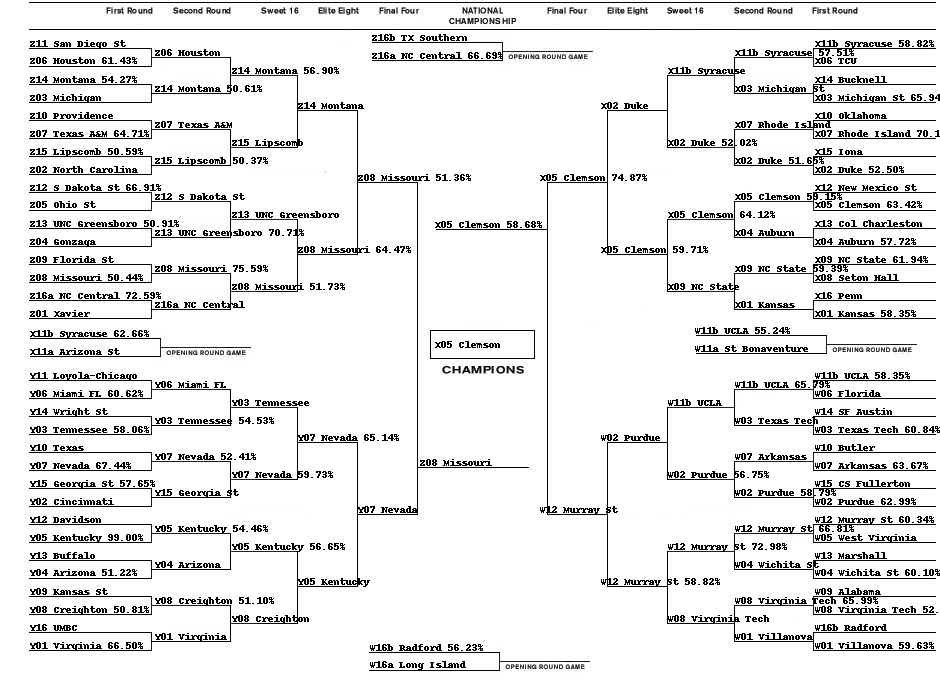

In [88]:
from bracketeer import build_bracket
b = build_bracket(
        outputPath='output.png',
        teamsPath='Teams.csv',
        seedsPath='NCAATourneySeeds.csv',
        submissionPath='submission_for_presentation.csv',
        slotsPath='NCAATourneySlots.csv',
        year=2018
)

from IPython.display import Image
Image("output.png")

In [45]:
bracket_1 = ['San Diego St', 'Houston', 'Montana', 'Michigan', 'Providence', 'Texas A&M', 'Lipscomb', 'North Carolina', 'S Dakota St', 'Ohio St',\
'UNC Greensboro', 'Gonzaga', 'Florida St', 'Missouri', 'NC Central', 'Xavier']

In [46]:
bracket_4 = ['UCLA', 'Florida', 'SF Austin', 'Texas Tech', 'Butler', 'Arkansas', 'CS Fullerton', 'Purdue', 'Murray St', \
            'West Virginia', 'Marshall', 'Wichita St', 'Alabama', 'Virginia Tech', 'Radford', 'Villanova']

In [47]:
bracket_3 = ['Syracuse', 'TCU', 'Bucknell', 'Michigan St', 'Oklahoma', 'Rhode Island', 'Iona', 'Duke', 'New Mexico St',\
            'Clemson', 'Col Charleston', 'Auburn', 'NC State', "Seton Hall", 'Penn', 'Kansas']

In [48]:
bracket_2 = ['Loyola-Chicago', 'Miami FL', 'Wright St', 'Tennessee', 'Texas', 'Nevada', 'Georgia St', 'Cincinnati', 'Davidson',\
            'Kentucky', 'Buffalo', 'Arizona', 'Kansas St', 'Creighton', 'UMBC', 'Virginia']

In [78]:
teams[teams['TeamName'] == 'Villanova']

,TeamID,TeamName,FirstD1Season,LastD1Season
336,1437,Villanova,1985,2018


In [50]:
teams.loc[teams['TeamName']== 'Syracuse', ['TeamID']].values[0][0]

1393

In [51]:
id_bracket1 = []
for i in bracket_1:
    id_bracket1.append(teams.loc[teams['TeamName']== i, ['TeamID']].values[0][0])

In [52]:
id_bracket2 = []
for i in bracket_2:
    id_bracket2.append(teams.loc[teams['TeamName']== i, ['TeamID']].values[0][0])

In [53]:
id_bracket3 = []
for i in bracket_3:
    id_bracket3.append(teams.loc[teams['TeamName']== i, ['TeamID']].values[0][0])

In [54]:
id_bracket4 = []
for i in bracket_4:
    id_bracket4.append(teams.loc[teams['TeamName']== i, ['TeamID']].values[0][0])

In [55]:
sample_sub = sample_sub_stage.ID.str.split('_', expand = True).rename(columns={0: 'Season', 1: 'team1',2: 'team2'})
sample = pd.concat([sample_sub_stage, sample_sub], axis = 1)
sample['Season'] = sample['Season'].astype('int64')
sample['team1'] = sample['team1'].astype('int64')
sample['team2'] = sample['team2'].astype('int64')

In [57]:
sample[sample['ID'] == '2018_1252_1314']

,ID,Pred,Season,team1,team2
1345,2018_1252_1314,0.5,2018,1252,1314


In [61]:
graph = ncaa_test(sample_sub_stage, reg_tour, regular_season_detailed)

In [62]:
graph['predictions'] = vc.predict(X_test_sc)

In [63]:
graph_feat = graph[['ID', 'team1', 'team2', 'team1seed', 'team2seed', 'team1_WEFG%_med', 'predictions']]

In [64]:
graph_df = pd.DataFrame(columns = ['ID', 'team1', 'team2', 'team1seed', 'team2seed', 'team1_WEFG%_med', 'predictions'])

In [65]:
ids = ['2018_1222_1361', '2018_1276_1285', '2018_1344_1401', '2018_1252_1314', '2018_1326_1355', '2018_1211_1422', '2018_1199_1281',\
'2018_1300_1462', '2018_1260_1274', '2018_1397_1460', '2018_1305_1400', '2018_1153_1209', '2018_1172_1246', '2018_1112_1138',\
'2018_1166_1243', '2018_1420_1438', '2018_1393_1395', '2018_1137_1277', '2018_1328_1348', '2018_1181_1233', '2018_1155_1308',\
'2018_1120_1158', '2018_1301_1371', '2018_1242_1355', '2018_1196_1417', '2018_1371_1403', '2018_1116_1139', '2018_1168_1345',\
'2018_1293_1452','2018_1267_1455', '2018_1104_1439', '2018_1347_1437']

In [66]:
for i in ids:
    graph_df = graph_df.append(graph_feat[graph_feat['ID'] == i], ignore_index = True)

In [67]:
won = graph_df[graph_df['predictions'] == 1]

In [68]:
lost = graph_df[graph_df['predictions'] == 0]

In [69]:
won.team1seed.values

array([6, 3, 5, 4, 3, 7, 2, 4, 8, 2, 5, 4, 1, 6, 7], dtype=object)

In [70]:
won.head()

,ID,team1,team2,team1seed,team2seed,team1_WEFG%_med,predictions
0,2018_1222_1361,1222,1361,6,11,0.529776,1
1,2018_1276_1285,1276,1285,3,14,0.546875,1
4,2018_1326_1355,1326,1355,5,12,0.537607,1
5,2018_1211_1422,1211,1422,4,13,0.589478,1
9,2018_1397_1460,1397,1460,3,14,0.511364,1


In [73]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

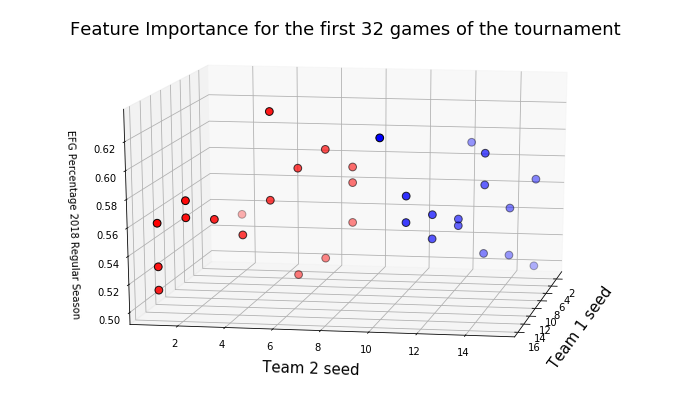

In [74]:

# woreb = det_18_vil['WOR'].values / (det_18_vil['WOR'].values + det_18_vil['LDR'].values) 
# wdreb = det_18_vil['WDR'].values / (det_18_vil['WDR'].values + det_18_vil['LOR'].values)

# arbitraty penalty term = 0.66 - some ft attempts stem from fg attempts
# this can obviously be changed to a different value

# loreb = det_18_cin['LOR'].values / (det_18_cin['LOR'].values + det_18_cin['WDR'].values) 
# ldreb = det_18_cin['LDR'].values / (det_18_cin['LDR'].values + det_18_cin['WOR'].values)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_title('Feature Importance for the first 32 games of the tournament', fontsize = 18)
ax.scatter(won.team1seed.values, won.team2seed.values, won['team1_WEFG%_med'].values, c='blue', s = 60, edgecolor = 'black')
ax.scatter(lost.team1seed.values, lost.team2seed, lost['team1_WEFG%_med'], c='red', s = 60, edgecolor = 'black')
ax.set_xlabel('Team 1 seed', fontsize = 15, labelpad = 10)
ax.set_ylabel('Team 2 seed', fontsize = 15, labelpad = 15)
ax.set_zlabel("EFG Percentage 2018 Regular Season", labelpad = 10)
ax.view_init(elev = 15, azim=10)

In [75]:
teams = pd.read_csv("Teams.csv")

In [77]:
teams[teams['TeamID'] == 1172]

,TeamID,TeamName,FirstD1Season,LastD1Season
71,1172,Davidson,1985,2018


In [ ]:
teams[teams[]]

In [89]:
lost

,ID,team1,team2,team1seed,team2seed,team1_WEFG%_med,predictions
2,2018_1344_1401,1344,1401,10,7,0.523810,0
3,2018_1252_1314,1252,1314,15,2,0.563109,0
6,2018_1199_1281,1199,1281,9,8,0.588214,0
7,2018_1300_1462,1300,1462,16,1,0.530277,0
8,2018_1260_1274,1260,1274,11,6,0.590909,0
12,2018_1172_1246,1172,1246,12,5,0.632653,0
15,2018_1420_1438,1420,1438,16,1,0.561224,0
16,2018_1393_1395,1393,1395,11,6,0.513906,0
17,2018_1137_1277,1137,1277,14,3,0.560000,0
18,2018_1328_1348,1328,1348,10,7,0.602597,0
